In [ ]:
import pandas as pd
from binance.client import Client
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer, precision_score
from itertools import combinations
from xgboost import XGBClassifier
import datetime
import pickle
import base64
from random import sample

In [ ]:
def get_historical_data(symbol, interval, days):
    # Calculate the start time (40 days ago from now)
    start_time = datetime.datetime.now() - datetime.timedelta(days=days)
    start_time_str = start_time.strftime('%Y-%m-%d %H:%M:%S')

    # Fetch historical klines data
    client = Client()
    klines = client.get_historical_klines(symbol, interval, start_time_str)
    
    # Convert to DataFrame
    klines_df = pd.DataFrame(klines)
    
    # Assign column names
    klines_df.columns = [
        'Open time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close time', 
        'Quote asset volume', 'Number of trades', 'Taker buy base asset volume', 
        'Taker buy quote asset volume', 'Ignore'
    ]
    
    # Data is supplied in UTC+0
    klines_df['Open time'] = pd.to_datetime(klines_df['Open time']/1000, unit = 's', utc=True).dt.tz_convert(tz='Europe/Berlin')
    klines_df['Close time'] = pd.to_datetime(klines_df['Close time']/1000, unit = 's', utc=True).dt.tz_convert(tz='Europe/Berlin')
    
    numeric_columns = [
        'Open', 'High', 'Low', 'Close', 'Volume', 'Quote asset volume',
        'Taker buy base asset volume', 'Taker buy quote asset volume'
    ]
    klines_df[numeric_columns] = klines_df[numeric_columns].apply(pd.to_numeric, axis=1)
    return klines_df

def make_signals(pred: pd.Series, holding_period: int):
    np_pred = pred
    for i in reversed(range(len(np_pred))):
        if np_pred[i] == 1:
            np_pred[i:i+holding_period] = 1
    np_pred = np_pred
    return np_pred 

# De-serialize an object from a plain text
def txt_to_obj(txt):
    base64_bytes = txt.encode('ascii')
    message_bytes = base64.b64decode(base64_bytes)
    obj = pickle.loads(message_bytes)
    return obj

def bot(data: pd.DataFrame):
    symbol = 'BTCEUR'
    days = 1000
    SIGNAL_TH = 0.55
    HOLDING_PERIOD = 24
    FEATURES = ['OBV', 'EMA_24_Sig', 'SMA_168_Sig']
    MODEL = ""
    
    # TODO: while true, sleep
    try:
        # Download Dataset
        bitcoin_data_hour = get_historical_data(symbol, Client.KLINE_INTERVAL_1HOUR, days)
        bitcoin_data_hour["pct"] = bitcoin_data_hour["Close"].pct_change().shift(-1) 
        bitcoin_data_hour.dropna(inplace=True)
        df_hour = bitcoin_data_hour
        
        # Make Indicators
        dt_indicators = []
        OBV_berechnen(df_hour)
        #MACD_berechnen(df_hour)
        dt_indicators.extend([f'OBV', f'MACD'])
        for i in [24, 24*7, 24*30]:#[5, 10, 20, 50, 100, 500, 1000]:
            SMA_berechnen(df_hour, i)
            #RSI_berechnen(df_hour, i)
            EMA_berechnen(df_hour, i)
            #HMA_berechnen(df_hour, i)
            #Momentum_berechnen(df_hour, i)
            #Stochastic_RSI_berechnen(df_hour, i)
        dt_indicators.extend([f"RSI_{i}", f"SMA_{i}_Sig", f"EMA_{i}_Sig", f"HMA_{i}_Sig", f"Momentum_{i}", f"StochRSI_{i}"])
    
        data = df_hour.reset_index(drop=True)
        X_test = data[FEATURES]
    
        # Load Model
        clf = txt_to_obj(MODEL) # TODO: Load model
        
        # Predict
        y_pred_proba = clf.predict_proba(X_test)
        y_pred = (y_pred_proba[:, 1] > SIGNAL_TH).astype(int)
        y_pred = make_signals(y_pred, HOLDING_PERIOD)
        prediction = y_pred[-1] #TODO:L  Order?
        if prediction == 1:
            return "BTC"
        else:
            return "EUR"
    except Exception as e:
        # Error handling in case API call doesn't work
        print(e)
        pass 
    
    print("SCHLECHT!")
    return "EUR" # or # "BTC"

In [ ]:
bot(None)

In [ ]:
TRANSACTION_COSTS = 0.0005
# Start investment is EURO!

In [ ]:
# Fetch Bitcoin prices at 5-minute intervals for the last 40 days
symbol = 'BTCEUR'
days = 10000

bitcoin_data_hour = get_historical_data(symbol, Client.KLINE_INTERVAL_1HOUR, days)
#bitcoin_data_5minute = get_historical_data(symbol, Client.KLINE_INTERVAL_5MINUTE, days)

In [ ]:
bitcoin_data_hour["Open time"]

In [ ]:
bitcoin_data_hour.shape

In [ ]:
bitcoin_data_hour["pct"] = bitcoin_data_hour["Close"].pct_change().shift(-1)    #time shift ist WICHTIG! einer der häufigsten Fehler, wenn er vergessen wird
#bitcoin_data_5minute["pct"] = bitcoin_data_5minute["Close"].pct_change().shift(-1)

In [ ]:
bitcoin_data_hour.dropna(inplace=True)
#bitcoin_data_5minute.dropna(inplace=True)

df_hour = bitcoin_data_hour
#df_5minute = bitcoin_data_5minute


In [ ]:
def sharpe_ratio(s):
    s = np.log(1+s)
    sharpe = s.mean() / s.std()
    print(f"mean={s.mean():.6f}, std={s.std():.6f}")
    return sharpe

In [ ]:
#Funktion um zu zählen wie häufig ein buy Signal hinter einander auftritt
def count_consecutive_ones(data: pd.DataFrame, signal_col: str):
    new_column_name = signal_col + "_count"
    
    count = 0
    counts = []
    
    for value in data[signal_col]:
        if value == 1:
            count += 1
        else:
            count = 0
        counts.append(count)
    
    data[new_column_name] = counts

### Indikatoren und Indexe berechnen

In [ ]:
def SMA_berechnen(data:pd.DataFrame, intervall:int):
    spalten_name = "SMA_"+str(intervall)
    data[spalten_name] = data["Close"].rolling(intervall).mean()
    spalten_name_sig = "SMA_"+str(intervall)+"_Sig"
    data[spalten_name_sig] = (data["Close"]>data[spalten_name]).astype(int)
    print(data[spalten_name_sig].mean())
    count_consecutive_ones(data, spalten_name_sig)
    
def RSI_berechnen(data:pd.DataFrame, intervall:int):

    spalten_name = "RSI_"+str(intervall)

    # Bestimme die Preisänderung zum jeweiligen Zeitpunkt t-1
    delta = np.log(data["Close"]).diff()

    # Get rid of the first row, which has NaN values
    delta = delta[1:]

    # Calculate the gains and losses
    up = delta.where(delta > 0, 0)
    down = -delta.where(delta < 0, 0)

    # Calculate the rolling average of the gains and losses
    #window_size = 14 #als default
    avg_gain = up.rolling(intervall).mean()
    avg_loss = down.rolling(intervall).mean()

    # Calculate the relative strength
    rs = avg_gain / avg_loss

    # Calculate the RSI
    data[spalten_name] = 100 - (100 / (1 + rs))
    
def EMA_berechnen(data: pd.DataFrame, intervall: int):
    spalten_name = "EMA_" + str(intervall)
    data[spalten_name] = data["Close"].ewm(span=intervall, adjust=False).mean()
    spalten_name_sig = "EMA_"+str(intervall)+"_Sig"
    data[spalten_name_sig] = (data["Close"]>data[spalten_name]).astype(int)
    count_consecutive_ones(data, spalten_name_sig)

def HMA_berechnen(data: pd.DataFrame, intervall: int):
    spalten_name = "HMA_" + str(intervall)
    half_length = int(intervall / 2)
    sqrt_length = int(np.sqrt(intervall))

    wma_half = data["Close"].rolling(window=half_length).mean()
    wma_full = data["Close"].rolling(window=intervall).mean()

    raw_hma = 2 * wma_half - wma_full
    data[spalten_name] = raw_hma.rolling(window=sqrt_length).mean()
    
    spalten_name_sig = "HMA_"+str(intervall)+"_Sig"
    data[spalten_name_sig] = (data["Close"]>data[spalten_name]).astype(int)
    count_consecutive_ones(data, spalten_name_sig)

def MACD_berechnen(data: pd.DataFrame, fast_period: int = 12, slow_period: int = 26, signal_period: int = 9):
    data["MACD"] = np.log(data["Close"]).ewm(span=fast_period, adjust=False).mean() - np.log(data["Close"]).ewm(span=slow_period, adjust=False).mean()
    data["MACD_Signal"] = data["MACD"].ewm(span=signal_period, adjust=False).mean()

def Momentum_berechnen(data: pd.DataFrame, intervall: int):
    spalten_name = "Momentum_" + str(intervall)
    data[spalten_name] = data["Close"].pct_change(intervall)

def Stochastic_RSI_berechnen(data: pd.DataFrame, intervall: int):
    spalten_name = "StochRSI_" + str(intervall)

    delta = np.log(data["Close"]).diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=intervall).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=intervall).mean()

    RS = gain / loss
    RSI = 100 - (100 / (1 + RS))

    min_RSI = RSI.rolling(window=intervall).min()
    max_RSI = RSI.rolling(window=intervall).max()

    data[spalten_name] = (RSI - min_RSI) / (max_RSI - min_RSI)

In [ ]:
dt_indicators = []
MACD_berechnen(df_hour)
dt_indicators.extend([f'MACD'])
for i in [24, 24*7, 24*30]:#[5, 10, 20, 50, 100, 500, 1000]:
    SMA_berechnen(df_hour, i)
    RSI_berechnen(df_hour, i)
    EMA_berechnen(df_hour, i)
    HMA_berechnen(df_hour, i)
    Momentum_berechnen(df_hour, i)
    Stochastic_RSI_berechnen(df_hour, i)
    dt_indicators.extend([f"RSI_{i}", f"SMA_{i}_Sig", f"EMA_{i}_Sig", f"HMA_{i}_Sig", f"Momentum_{i}", f"StochRSI_{i}"])
    

In [ ]:
df_hour["Hour"] = df_hour["Open time"].dt.hour
tmp = df_hour.groupby("Hour")["pct"].mean()
plt.bar(x=tmp.index, height=tmp)

In [ ]:
# Calendar Effects:
df_hour["Is_AfterHour"] = df_hour["Open time"].dt.hour >= 22
df_hour["Is_Monday"] = df_hour["Open time"].dt.day_of_week == 0
dt_indicators.extend([f'Is_AfterHour', f'Is_Monday'])

In [ ]:
#berechnet performance für das gewollte Zeitfenster
def create_labels(df: pd.DataFrame, window: int):
    data = df.copy()
    data["future_return"] = data["Close"].shift(-window) / data["Close"] - 1
    data["label"] = (data["future_return"] > TRANSACTION_COSTS*2).astype(int)
    data.dropna(inplace=True)
    data.reset_index(drop=True, inplace=True)
    return data

In [ ]:
from sklearn import tree
def train_model(data: pd.DataFrame, features: list, target: str, param_grid, estimator):
    # Indizes zurücksetzen, um Probleme mit der Indizierung zu vermeiden
    data = data.reset_index(drop=True)
    
    # Aufteilen der Daten in Trainings- und Testdaten
    train_size = int(len(data) * 0.8)
    train_data = data.iloc[:train_size]
    test_data = data.iloc[train_size:]
    X_train = train_data[features].dropna()
    X_test = test_data[features]
    y_train = train_data[target]
    
    # Definiere den Precision-Scorer
    precision_scorer = make_scorer(precision_score, pos_label=1)
    
    # Initialisiere den GridSearchCV
    grid_search = GridSearchCV(estimator=estimator,
                               param_grid=param_grid,
                                cv=4,  # Anzahl der Cross-Validation-Folds
                                scoring=precision_scorer,  # Bewertungskriterium
                                n_jobs=-1,  # Nutze alle verfügbaren CPU-Kerne
                                verbose=2)  # Ausgabe von Fortschrittsinformationen

     # Führe GridSearch aus
    grid_search.fit(X_train, y_train)
    
    # Ausgabe der besten Parameter
    print("Beste Parameter:", grid_search.best_params_)
    
    # Modell mit den besten Parametern
    best_clf = grid_search.best_estimator_
    return best_clf, X_test, X_train
    
def make_signals(pred: pd.Series, holding_period: int):
    np_pred = pred
    for i in reversed(range(len(np_pred))):
        if np_pred[i] == 1:
            np_pred[i:i+holding_period] = 1
    np_pred = np_pred
    return np_pred 
    
def evaluate_model(X_test, best_clf, data, signal_threshold, holding_period, plot=True, print=False):
    # Vorhersagen auf Testdaten
    #y_pred = best_clf.predict(X_test)
    
    #best_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
    #best_clf.fit(X_train, y_train)
    
    # TODO print out sharpe ratio in training data set
    # y_pred_proba = best_clf.predict_proba(X_train)
    # y_pred = (y_pred_proba[:, 1] > signal_threshold).astype(int)
    # y_pred = make_signals(y_pred, holding_period)
    # print(f"Sharpe Strategy (Train): {sharpe}")

    # Get the predicted probabilities
    y_pred_proba = best_clf.predict_proba(X_test)
    y_pred = (y_pred_proba[:, 1] > signal_threshold).astype(int)
    y_pred = make_signals(y_pred, holding_period)
    
    # Berechne die Sharpe Ratio
    test_returns = data.loc[X_test.index, "pct"]
    if print: 
        print(f'Sharpe BTC {sharpe_ratio(test_returns)}')

    strat_returns = test_returns.copy()
    strat_returns[y_pred == 0] = 0

    # Calculate transaction costs: a cost occurs whenever there is a change in the position (buy/sell)
    positions = np.diff(np.concatenate([[0], y_pred]))  # Calculate position changes
    transaction_costs = np.abs(positions) * TRANSACTION_COSTS  # Apply transaction costs

    sharpe = sharpe_ratio(strat_returns)
    if print: 
        print(f"Sharpe Ratio without costs: {sharpe}")
    strat_returns -= transaction_costs  # Deduct transaction costs from strategy returns

    if print: 
        print(f"number of transactions {np.sum(np.abs(positions))}")

    sharpe = sharpe_ratio(strat_returns)
    if print: 
        print(f"Sharpe Ratio with costs: {sharpe}")
    
    # Performance DataFrame erstellen
    if plot:
        # Performance DataFrame erstellen
        PF = pd.DataFrame(data["pct"].iloc[X_test.index])
        PF["pred"] = y_pred
        PF["strategy_returns"] = PF["pred"] * PF["pct"]
        PF["cumulative_strategy_returns"] = (PF["strategy_returns"] + 1).cumprod()

        PF["benchmark_returns"] = PF["pct"]
        PF["cumulative_benchmark_returns"] = (PF["benchmark_returns"] + 1).cumprod()

        # Calculate transaction indices
        transaction_indices = np.where(np.abs(positions) > 0)[0]

        # Adjust transaction_indices to match PF index
        transaction_indices = transaction_indices[transaction_indices < len(PF)]

        # Plot results
        plt.figure(figsize=(14, 7))
        plt.plot(PF["cumulative_strategy_returns"], label="Strategy Returns")
        plt.plot(PF["cumulative_benchmark_returns"], label="Benchmark Returns")

        # Add dots where transactions occur
        plt.scatter(PF.index[transaction_indices], 
                    PF["cumulative_strategy_returns"].iloc[transaction_indices],
                    color='red', 
                    marker='o', 
                    label='Transactions')

        plt.title("Cumulative Returns with Transactions")
        plt.xlabel("Time")
        plt.ylabel("Cumulative Returns")
        plt.yscale("log")
        plt.legend()
        plt.show()
    
    return sharpe

In [316]:

def find_best_indicators(data: pd.DataFrame, indicators: list, target: str, holding_period, signal_threshold, plot=True):
    best_sharpe = -np.inf
    best_combination = None
    best_model = None

    # Definiere den Parameterbereich für GridSearch
    param_grid = {
        #'criterion': ['gini', 'entropy'],
        #'max_depth': [2, 3, 4],
        #'min_samples_split': [2, 5, 10],
        #'min_samples_leaf': [5, 10, 20, 30],
        #'max_features': ['sqrt']
    }
    max_n_of_models = 100
    models = []
    train_sharpe_ratios = []
    test_sharpe_ratios = []
    combos = []
    for r in [3, 4, 5, 6]:
        for combo in sample(list(combinations(indicators, r)), max_n_of_models):
            features = list(combo)
            clf, X_test, X_train = train_model(data, features, target, param_grid=param_grid, estimator=XGBClassifier(max_depth=3, 
                                                                                                                      random_state=42,
                                                                                                                      tree_method='hist'))
            
            train_sharpe = evaluate_model(X_train, clf, signal_threshold=signal_threshold, holding_period=holding_period, data=data, plot=plot)
            test_sharpe = evaluate_model(X_test, clf, signal_threshold=signal_threshold, holding_period=holding_period, data=data, plot=plot)

            train_sharpe_ratios.append(train_sharpe)
            test_sharpe_ratios.append(test_sharpe)
            models.append(clf)
            combos.append(features)
            
            if test_sharpe > best_sharpe:
                best_sharpe = test_sharpe
                best_combination = combo
                best_model = clf

    #print(f"Best Sharpe Ratio: {best_sharpe}")
    print(f"Best Indicator Combination: {best_combination}")

    return best_model, best_combination, best_sharpe, train_sharpe_ratios, test_sharpe_ratios, models, combos

# Finding optimal holding period

Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000139, std=0.004339
mean=0.000126, std=0.004340
mean=0.000007, std=0.002280
mean=-0.000001, std=0.002278
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000144, std=0.004752
mean=0.000129, std=0.004752
mean=0.000035, std=0.002860
mean=0.000025, std=0.002861
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000028, std=0.001866
mean=0.000024, std=0.001866
mean=0.000020, std=0.001444
mean=0.000013, std=0.001444
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000158, std=0.003945
mean=0.000148, std=0.003946
mean=0.000018, std=0.002580
mean=0.000008, std=0.002580
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000071, std=0.003082
mean=0.000058, std=0.003082
mean=0.000040, std=0.002468
mean=0.000027, std=0.002468
Fitting 4 folds for each of 1 candidates, to

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000115, std=0.003929
mean=0.000105, std=0.003930
mean=0.000001, std=0.002407
mean=-0.000008, std=0.002404
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000000, std=0.000000
mean=0.000000, std=0.000000
mean=0.000000, std=0.000000
mean=0.000000, std=0.000000
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000011, std=0.000786
mean=0.000008, std=0.000783
mean=0.000015, std=0.000774
mean=0.000012, std=0.000775
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000040, std=0.001738
mean=0.000033, std=0.001737
mean=0.000018, std=0.001199
mean=0.000011, std=0.001200
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000042, std=0.002025
mean=0.000037, std=0.002024
mean=0.000007, std=0.001352
mean=0.000003, std=0.001351
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000000, std=0.000000
mean=0.000000, std=0.000000
mean=0.000000, std=0.000000
mean=0.000000, std=0.000000
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000061, std=0.003218
mean=0.000052, std=0.003217
mean=0.000030, std=0.002301
mean=0.000024, std=0.002299
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000025, std=0.001791
mean=0.000019, std=0.001789
mean=0.000017, std=0.001409
mean=0.000012, std=0.001407
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000128, std=0.003618
mean=0.000119, std=0.003617
mean=-0.000020, std=0.002520
mean=-0.000027, std=0.002524
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000039, std=0.001834
mean=0.000032, std=0.001834
mean=0.000013, std=0.001243
mean=0.000006, std=0.001245
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000049, std=0.002615
mean=0.000043, std=0.002615
mean=0.000006, std=0.001186
mean=0.000002, std=0.001187
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000145, std=0.00

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000182, std=0.004467
mean=0.000168, std=0.004466
mean=-0.000005, std=0.002871
mean=-0.000016, std=0.002873
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000071, std=0.002133
mean=0.000062, std=0.002133
mean=0.000041, std=0.001829
mean=0.000030, std=0.001827
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000000, std=0.000000
mean=0.000000, std=0.000000
mean=0.000000, std=0.000000
mean=0.000000, std=0.000000
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000146, std=0.003874
mean=0.000135, std=0.003874
mean=-0.000003, std=0.002909
mean=-0.000013, std=0.002913
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000065, std=0.003326
mean=0.000058, std=0.003327
mean=0.000003, std=0.001730
mean=-0.000003, std=0.001729
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000195, std=0.004637
mean=0.000181, std=0.004636
mean=0.000039, std=0.002608
mean=0.000027, std=0.002607
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000089, std=0.002678
mean=0.000082, std=0.002679
mean=0.000001, std=0.002306
mean=-0.000009, std=0.002305
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000056, std=0.003611
mean=0.000049, std=0.003612
mean=0.000037, std=0.001926
mean=0.000032, std=0.001929
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000062, std=0.

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000142, std=0.004155
mean=0.000131, std=0.004155
mean=0.000017, std=0.002615
mean=0.000009, std=0.002615
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000023, std=0.001224
mean=0.000019, std=0.001224
mean=0.000013, std=0.000908
mean=0.000010, std=0.000906
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000048, std=0.003914
mean=0.000041, std=0.003915
mean=0.000001, std=0.001245
mean=-0.000004, std=0.001246
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000082, std=0.002991
mean=0.000072, std=0.002991
mean=0.000052, std=0.002229
mean=0.000041, std=0.002226
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000115, std=0.003881
mean=0.000107, std=0.003882
mean=0.000045, std=0.002258
mean=0.000039, std=0.002256
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000127, std=0.003

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000174, std=0.004402
mean=0.000164, std=0.004403
mean=0.000018, std=0.002483
mean=0.000010, std=0.002480
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000198, std=0.004538
mean=0.000183, std=0.004539
mean=0.000026, std=0.002929
mean=0.000014, std=0.002930
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000161, std=0.003503
mean=0.000152, std=0.003503
mean=0.000005, std=0.002522
mean=-0.000001, std=0.002522
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000037, std=0.002293
mean=0.000029, std=0.002293
mean=0.000029, std=0.001416
mean=0.000022, std=0.001414
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000055, std=0.003105
mean=0.000050, std=0.003105
mean=-0.000013, std=0.001574
mean=-0.000017, std=0.001574
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000102, std=0.0

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000071, std=0.003947
mean=0.000062, std=0.003947
mean=0.000011, std=0.001695
mean=0.000006, std=0.001697
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000138, std=0.003997
mean=0.000130, std=0.003997
mean=0.000001, std=0.002049
mean=-0.000006, std=0.002049
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000138, std=0.004115
mean=0.000125, std=0.004115
mean=0.000005, std=0.001754
mean=-0.000005, std=0.001758
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000027, std=0.001238
mean=0.000022, std=0.001238
mean=0.000005, std=0.001062
mean=-0.000000, std=0.001062
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000052, std=0.001906
mean=0.000045, std=0.001905
mean=0.000019, std=0.001520
mean=0.000012, std=0.001520
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000030, std=0.0

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000040, std=0.002138
mean=0.000032, std=0.002137
mean=0.000021, std=0.001617
mean=0.000012, std=0.001619
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000130, std=0.004272
mean=0.000117, std=0.004271
mean=0.000013, std=0.002586
mean=0.000003, std=0.002588
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000118, std=0.004113
mean=0.000106, std=0.004114
mean=0.000011, std=0.001947
mean=0.000000, std=0.001946
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000143, std=0.004101
mean=0.000133, std=0.004103
mean=0.000021, std=0.002634
mean=0.000013, std=0.002632
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000150, std=0.004555
mean=0.000138, std=0.004555
mean=-0.000000, std=0.002955
mean=-0.000011, std=0.002958
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000131, std=0.00

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000194, std=0.004516
mean=0.000181, std=0.004516
mean=0.000010, std=0.002383
mean=0.000001, std=0.002383
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000150, std=0.004017
mean=0.000136, std=0.004016
mean=0.000033, std=0.002439
mean=0.000022, std=0.002439
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000132, std=0.004803
mean=0.000119, std=0.004803
mean=0.000037, std=0.002681
mean=0.000030, std=0.002681
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000028, std=0.001520
mean=0.000023, std=0.001520
mean=0.000010, std=0.001081
mean=0.000005, std=0.001081
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000081, std=0.004051
mean=0.000072, std=0.004051
mean=0.000034, std=0.001948
mean=0.000030, std=0.001941
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000151, std=0.0037

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000042, std=0.003149
mean=0.000038, std=0.003149
mean=0.000002, std=0.001531
mean=-0.000003, std=0.001532
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000139, std=0.003991
mean=0.000129, std=0.003991
mean=-0.000015, std=0.002425
mean=-0.000022, std=0.002427
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000171, std=0.004303
mean=0.000159, std=0.004303
mean=0.000015, std=0.002541
mean=0.000006, std=0.002544
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000113, std=0.003401
mean=0.000098, std=0.003399
mean=0.000038, std=0.002716
mean=0.000022, std=0.002718
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000181, std=0.004508
mean=0.000167, std=0.004508
mean=0.000040, std=0.002586
mean=0.000030, std=0.002584
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000117, std=0.0

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000000, std=0.000000
mean=0.000000, std=0.000000
mean=0.000000, std=0.000000
mean=0.000000, std=0.000000
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000207, std=0.004863
mean=0.000193, std=0.004863
mean=0.000020, std=0.002793
mean=0.000011, std=0.002797
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000151, std=0.004129
mean=0.000140, std=0.004130
mean=-0.000016, std=0.002797
mean=-0.000025, std=0.002802
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000183, std=0.003922
mean=0.000172, std=0.003923
mean=0.000050, std=0.002422
mean=0.000041, std=0.002423
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000039, std=0.002236
mean=0.000031, std=0.002236
mean=0.000013, std=0.001752
mean=0.000004, std=0.001754
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000163, std=0.004271
mean=0.000154, std=0.004272
mean=-0.000001, std=0.002244
mean=-0.000007, std=0.002245
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000154, std=0.

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000087, std=0.002726
mean=0.000075, std=0.002726
mean=0.000035, std=0.002529
mean=0.000022, std=0.002528
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000178, std=0.004343
mean=0.000165, std=0.004345
mean=0.000009, std=0.002832
mean=-0.000003, std=0.002832
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000053, std=0.002317
mean=0.000048, std=0.002316
mean=0.000028, std=0.001899
mean=0.000024, std=0.001899
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000134, std=0.003049
mean=0.000127, std=0.003049
mean=0.000001, std=0.002559
mean=-0.000007, std=0.002561
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000178, std=0.004796
mean=0.000163, std=0.004796
mean=0.000020, std=0.002615
mean=0.000011, std=0.002616
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000056, std=0.00

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000122, std=0.004285
mean=0.000109, std=0.004285
mean=0.000036, std=0.002243
mean=0.000027, std=0.002245
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000160, std=0.004730
mean=0.000148, std=0.004731
mean=0.000010, std=0.002441
mean=0.000001, std=0.002442
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000104, std=0.002601
mean=0.000095, std=0.002601
mean=0.000003, std=0.002104
mean=-0.000008, std=0.002106
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000143, std=0.003153
mean=0.000131, std=0.003151
mean=0.000011, std=0.002496
mean=-0.000003, std=0.002499
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000045, std=0.002275
mean=0.000039, std=0.002276
mean=0.000011, std=0.001840
mean=0.000004, std=0.001841
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000067, std=0.00

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000102, std=0.003735
mean=0.000092, std=0.003736
mean=0.000008, std=0.002115
mean=0.000001, std=0.002113
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000185, std=0.004518
mean=0.000170, std=0.004518
mean=-0.000007, std=0.002734
mean=-0.000018, std=0.002737
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000130, std=0.003558
mean=0.000123, std=0.003559
mean=0.000012, std=0.001917
mean=0.000007, std=0.001912
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000192, std=0.004233
mean=0.000180, std=0.004232
mean=-0.000007, std=0.002813
mean=-0.000017, std=0.002812
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000065, std=0.003225
mean=0.000058, std=0.003225
mean=-0.000009, std=0.001701
mean=-0.000014, std=0.001701
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000142, std=

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000157, std=0.004158
mean=0.000144, std=0.004158
mean=0.000012, std=0.002763
mean=0.000002, std=0.002767
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000101, std=0.003404
mean=0.000094, std=0.003403
mean=0.000038, std=0.002086
mean=0.000030, std=0.002087
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000145, std=0.004144
mean=0.000134, std=0.004145
mean=0.000038, std=0.002668
mean=0.000028, std=0.002668
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000049, std=0.001879
mean=0.000044, std=0.001880
mean=0.000026, std=0.001483
mean=0.000021, std=0.001480
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000028, std=0.001583
mean=0.000024, std=0.001582
mean=0.000005, std=0.001813
mean=-0.000002, std=0.001815
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000153, std=0.004

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000000, std=0.000000
mean=0.000000, std=0.000000
mean=0.000000, std=0.000000
mean=0.000000, std=0.000000
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000210, std=0.004711
mean=0.000195, std=0.004710
mean=-0.000022, std=0.003119
mean=-0.000035, std=0.003120
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000174, std=0.004480
mean=0.000163, std=0.004480
mean=0.000050, std=0.002635
mean=0.000041, std=0.002636
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000109, std=0.003018
mean=0.000095, std=0.003017
mean=0.000035, std=0.002346
mean=0.000022, std=0.002347
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000163, std=0.004733
mean=0.000149, std=0.004733
mean=0.000034, std=0.002698
mean=0.000024, std=0.002700
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000170, std=0.004335
mean=0.000158, std=0.004335
mean=-0.000009, std=0.001982
mean=-0.000019, std=0.001984
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000061, std=0.

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000053, std=0.002098
mean=0.000045, std=0.002097
mean=0.000025, std=0.001657
mean=0.000015, std=0.001657
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000138, std=0.004314
mean=0.000128, std=0.004315
mean=0.000036, std=0.002711
mean=0.000026, std=0.002711
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000170, std=0.004379
mean=0.000158, std=0.004380
mean=0.000009, std=0.002767
mean=0.000001, std=0.002767
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000169, std=0.004680
mean=0.000155, std=0.004682
mean=0.000017, std=0.002364
mean=0.000005, std=0.002363
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000233, std=0.004849
mean=0.000218, std=0.004849
mean=-0.000005, std=0.002916
mean=-0.000017, std=0.002919
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000213, std=0.00

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000116, std=0.004581
mean=0.000105, std=0.004582
mean=0.000011, std=0.002963
mean=-0.000000, std=0.002963
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000091, std=0.003234
mean=0.000081, std=0.003237
mean=-0.000007, std=0.002724
mean=-0.000018, std=0.002723
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000027, std=0.002695
mean=0.000024, std=0.002696
mean=0.000010, std=0.001833
mean=0.000006, std=0.001829
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000072, std=0.002921
mean=0.000061, std=0.002921
mean=0.000045, std=0.002104
mean=0.000034, std=0.002100
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000023, std=0.001957
mean=0.000018, std=0.001957
mean=-0.000013, std=0.001370
mean=-0.000019, std=0.001374
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000015, std=0

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000174, std=0.004293
mean=0.000166, std=0.004294
mean=0.000007, std=0.002904
mean=0.000000, std=0.002906
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000000, std=0.000000
mean=0.000000, std=0.000000
mean=0.000000, std=0.000000
mean=0.000000, std=0.000000
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000146, std=0.004894
mean=0.000133, std=0.004894
mean=0.000033, std=0.002998
mean=0.000021, std=0.002998
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000111, std=0.004153
mean=0.000098, std=0.004155
mean=0.000027, std=0.002898
mean=0.000013, std=0.002899
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000112, std=0.004179
mean=0.000105, std=0.004179
mean=0.000018, std=0.002113
mean=0.000015, std=0.002114
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000108, std=0.004761
mean=0.000098, std=0.004761
mean=0.000017, std=0.002842
mean=0.000010, std=0.002841
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000036, std=0.002629
mean=0.000032, std=0.002630
mean=0.000000, std=0.001636
mean=-0.000005, std=0.001634
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000152, std=0.004

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000106, std=0.003866
mean=0.000099, std=0.003867
mean=0.000018, std=0.002846
mean=0.000010, std=0.002847
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000000, std=0.000000
mean=0.000000, std=0.000000
mean=0.000000, std=0.000000
mean=0.000000, std=0.000000
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000030, std=0.001975
mean=0.000025, std=0.001975
mean=0.000010, std=0.001208
mean=0.000006, std=0.001208
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000000, std=0.000000
mean=0.000000, std=0.000000
mean=0.000000, std=0.000000
mean=0.000000, std=0.000000
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000096, std=0.002747
mean=0.000087, std=0.002748
mean=-0.000013, std=0.001889
mean=-0.000022, std=0.001893
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000200, std=0.004990
mean=0.000187, std=0.004992
mean=0.000020, std=0.003328
mean=0.000007, std=0.003330
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000114, std=0.003710
mean=0.000109, std=0.003711
mean=0.000009, std=0.001986
mean=0.000005, std=0.001985
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000168, std=0.004930
mean=0.000155, std=0.004930
mean=0.000058, std=0.003077
mean=0.000048, std=0.003077
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000119, std=0.005181
mean=0.000105, std=0.005182
mean=0.000028, std=0.003092
mean=0.000015, std=0.003093
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000179, std=0.00

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000000, std=0.000000
mean=0.000000, std=0.000000
mean=0.000000, std=0.000000
mean=0.000000, std=0.000000
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000192, std=0.004809
mean=0.000181, std=0.004809
mean=0.000016, std=0.003157
mean=0.000007, std=0.003159
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000106, std=0.004569
mean=0.000094, std=0.004569
mean=0.000007, std=0.003088
mean=-0.000002, std=0.003089
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000089, std=0.004335
mean=0.000078, std=0.004335
mean=0.000013, std=0.002745
mean=0.000005, std=0.002746
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000006, std=0.001418
mean=0.000003, std=0.001418
mean=0.000001, std=0.000646
mean=-0.000002, std=0.000647
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000193, std=0.004659
mean=0.000178, std=0.004659
mean=0.000044, std=0.002900
mean=0.000032, std=0.002899
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000162, std=0.00

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000054, std=0.003053
mean=0.000049, std=0.003053
mean=0.000018, std=0.001777
mean=0.000014, std=0.001779
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000000, std=0.000000
mean=0.000000, std=0.000000
mean=0.000000, std=0.000000
mean=0.000000, std=0.000000
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000017, std=0.001709
mean=0.000012, std=0.001710
mean=-0.000010, std=0.001096
mean=-0.000015, std=0.001098
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000062, std=0.002913
mean=0.000053, std=0.002914
mean=-0.000006, std=0.002195
mean=-0.000014, std=0.002199
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000121, std=0.004699
mean=0.000108, std=0.004699
mean=0.000031, std=0.002627
mean=0.000022, std=0.002628
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000000, std=0.000000
mean=0.000000, std=0.000000
mean=0.000000, std=0.000000
mean=0.000000, std=0.000000
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000121, std=0.004770
mean=0.000109, std=0.004771
mean=0.000046, std=0.002844
mean=0.000035, std=0.002846
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000185, std=0.005012
mean=0.000175, std=0.005013
mean=0.000033, std=0.003022
mean=0.000025, std=0.003025
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000036, std=0.002939
mean=0.000027, std=0.002940
mean=-0.000011, std=0.002083
mean=-0.000020, std=0.002086
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000096, std=0.004139
mean=0.000089, std=0.004139
mean=0.000013, std=0.002316
mean=0.000006, std=0.002316
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000148, std=0.004204
mean=0.000135, std=0.004205
mean=0.000047, std=0.002958
mean=0.000034, std=0.002958
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000121, std=0.00

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000119, std=0.004692
mean=0.000104, std=0.004693
mean=0.000047, std=0.003078
mean=0.000034, std=0.003078
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000084, std=0.003688
mean=0.000075, std=0.003689
mean=0.000015, std=0.002175
mean=0.000008, std=0.002176
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000162, std=0.004071
mean=0.000145, std=0.004071
mean=0.000063, std=0.003142
mean=0.000043, std=0.003142
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000098, std=0.003629
mean=0.000087, std=0.003629
mean=0.000026, std=0.002282
mean=0.000014, std=0.002284
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000155, std=0.004388
mean=0.000141, std=0.004389
mean=0.000022, std=0.002979
mean=0.000010, std=0.002980
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000129, std=0.0051

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000076, std=0.002933
mean=0.000065, std=0.002932
mean=0.000028, std=0.001873
mean=0.000019, std=0.001873
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000141, std=0.004565
mean=0.000130, std=0.004565
mean=0.000012, std=0.003234
mean=0.000001, std=0.003234
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000132, std=0.004258
mean=0.000122, std=0.004259
mean=-0.000008, std=0.002693
mean=-0.000016, std=0.002694
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000029, std=0.003516
mean=0.000025, std=0.003517
mean=-0.000000, std=0.001669
mean=-0.000004, std=0.001670
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000056, std=0.002465
mean=0.000049, std=0.002467
mean=0.000045, std=0.001941
mean=0.000037, std=0.001941
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000122, std=0.

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000219, std=0.004802
mean=0.000210, std=0.004803
mean=-0.000002, std=0.003326
mean=-0.000011, std=0.003327
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000062, std=0.004238
mean=0.000054, std=0.004238
mean=0.000043, std=0.002269
mean=0.000037, std=0.002265
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000127, std=0.004737
mean=0.000113, std=0.004737
mean=0.000028, std=0.002952
mean=0.000017, std=0.002956
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000096, std=0.004535
mean=0.000085, std=0.004536
mean=0.000046, std=0.002788
mean=0.000038, std=0.002789
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000184, std=0.005014
mean=0.000173, std=0.005015
mean=0.000023, std=0.002934
mean=0.000015, std=0.002933
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000042, std=0.00

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000122, std=0.003615
mean=0.000109, std=0.003616
mean=0.000029, std=0.002841
mean=0.000015, std=0.002842
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000144, std=0.004818
mean=0.000131, std=0.004818
mean=0.000006, std=0.002734
mean=-0.000004, std=0.002734
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000044, std=0.002428
mean=0.000041, std=0.002428
mean=0.000020, std=0.001854
mean=0.000015, std=0.001853
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000155, std=0.003941
mean=0.000145, std=0.003944
mean=0.000043, std=0.002728
mean=0.000031, std=0.002727
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000046, std=0.004326
mean=0.000038, std=0.004326
mean=0.000043, std=0.002378
mean=0.000037, std=0.002377
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000039, std=0.002

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000125, std=0.003692
mean=0.000110, std=0.003693
mean=-0.000001, std=0.002865
mean=-0.000018, std=0.002867
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000068, std=0.002589
mean=0.000061, std=0.002590
mean=0.000005, std=0.002109
mean=-0.000003, std=0.002110
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000195, std=0.004740
mean=0.000186, std=0.004740
mean=0.000033, std=0.002778
mean=0.000025, std=0.002780
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000181, std=0.004424
mean=0.000170, std=0.004424
mean=-0.000010, std=0.002803
mean=-0.000018, std=0.002806
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000222, std=0.004813
mean=0.000209, std=0.004813
mean=0.000044, std=0.003279
mean=0.000031, std=0.003279
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000168, std=0

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000098, std=0.004205
mean=0.000089, std=0.004206
mean=0.000031, std=0.002565
mean=0.000026, std=0.002569
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000049, std=0.003669
mean=0.000040, std=0.003669
mean=0.000006, std=0.002659
mean=-0.000001, std=0.002657
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000060, std=0.002807
mean=0.000049, std=0.002808
mean=0.000036, std=0.001980
mean=0.000026, std=0.001981
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000154, std=0.004790
mean=0.000142, std=0.004790
mean=0.000016, std=0.002988
mean=0.000009, std=0.002986
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000032, std=0.002788
mean=0.000025, std=0.002788
mean=-0.000023, std=0.002007
mean=-0.000030, std=0.002011
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000000, std=0.0

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000060, std=0.004291
mean=0.000052, std=0.004292
mean=0.000034, std=0.002603
mean=0.000026, std=0.002601
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000107, std=0.004630
mean=0.000095, std=0.004630
mean=0.000016, std=0.002813
mean=0.000008, std=0.002814
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000000, std=0.000000
mean=0.000000, std=0.000000
mean=0.000000, std=0.000000
mean=0.000000, std=0.000000
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000124, std=0.004398
mean=0.000114, std=0.004398
mean=0.000022, std=0.003110
mean=0.000010, std=0.003113
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000133, std=0.004580
mean=0.000121, std=0.004580
mean=0.000004, std=0.002906
mean=-0.000007, std=0.002906
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000108, std=0.003531
mean=0.000099, std=0.003531
mean=0.000001, std=0.002499
mean=-0.000007, std=0.002500
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000125, std=0.004506
mean=0.000113, std=0.004506
mean=0.000030, std=0.002165
mean=0.000021, std=0.002166
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000035, std=0.002044
mean=0.000028, std=0.002044
mean=0.000002, std=0.001942
mean=-0.000009, std=0.001947
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000071, std=0.0

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000112, std=0.004224
mean=0.000099, std=0.004224
mean=0.000000, std=0.002545
mean=-0.000013, std=0.002547
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000032, std=0.002259
mean=0.000024, std=0.002260
mean=-0.000009, std=0.001539
mean=-0.000018, std=0.001544
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000080, std=0.004273
mean=0.000072, std=0.004273
mean=0.000009, std=0.002326
mean=0.000001, std=0.002324
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000137, std=0.003974
mean=0.000122, std=0.003974
mean=0.000047, std=0.002616
mean=0.000032, std=0.002617
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000130, std=0.004329
mean=0.000120, std=0.004330
mean=0.000026, std=0.002690
mean=0.000016, std=0.002690
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000105, std=0.0

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000082, std=0.003531
mean=0.000074, std=0.003531
mean=0.000006, std=0.002195
mean=-0.000002, std=0.002195
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000055, std=0.002860
mean=0.000050, std=0.002860
mean=0.000033, std=0.002081
mean=0.000029, std=0.002084
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000000, std=0.000000
mean=0.000000, std=0.000000
mean=0.000000, std=0.000000
mean=0.000000, std=0.000000
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000020, std=0.001366
mean=0.000016, std=0.001366
mean=-0.000004, std=0.001193
mean=-0.000008, std=0.001198
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000012, std=0.001837
mean=0.000007, std=0.001838
mean=-0.000027, std=0.001202
mean=-0.000031, std=0.001203
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000140, std=0.004619
mean=0.000130, std=0.004620
mean=0.000040, std=0.002957
mean=0.000031, std=0.002956
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000120, std=0.003614
mean=0.000109, std=0.003615
mean=0.000051, std=0.002645
mean=0.000039, std=0.002646
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000181, std=0.004793
mean=0.000168, std=0.004794
mean=0.000024, std=0.003245
mean=0.000013, std=0.003247
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000107, std=0.

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000030, std=0.002390
mean=0.000026, std=0.002391
mean=0.000032, std=0.002182
mean=0.000027, std=0.002182
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000027, std=0.002504
mean=0.000023, std=0.002505
mean=0.000026, std=0.001958
mean=0.000022, std=0.001958
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000108, std=0.004909
mean=0.000099, std=0.004908
mean=0.000022, std=0.002981
mean=0.000016, std=0.002983
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000150, std=0.004787
mean=0.000140, std=0.004786
mean=0.000018, std=0.002625
mean=0.000009, std=0.002625
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000156, std=0.005307
mean=0.000142, std=0.005307
mean=0.000021, std=0.003363
mean=0.000008, std=0.003364
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000076, std=0.0039

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000090, std=0.002751
mean=0.000079, std=0.002750
mean=-0.000032, std=0.002251
mean=-0.000042, std=0.002251
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000143, std=0.004626
mean=0.000135, std=0.004626
mean=0.000017, std=0.002488
mean=0.000012, std=0.002488
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000000, std=0.000000
mean=0.000000, std=0.000000
mean=0.000000, std=0.000000
mean=0.000000, std=0.000000
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000199, std=0.005086
mean=0.000186, std=0.005087
mean=0.000022, std=0.003417
mean=0.000010, std=0.003417
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000193, std=0.005114
mean=0.000179, std=0.005115
mean=0.000020, std=0.002745
mean=0.000011, std=0.002745
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000160, std=0.004845
mean=0.000144, std=0.004846
mean=0.000051, std=0.003360
mean=0.000035, std=0.003358
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000000, std=0.000000
mean=0.000000, std=0.000000
mean=0.000000, std=0.000000
mean=0.000000, std=0.000000
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000158, std=0.004993
mean=0.000144, std=0.004993
mean=0.000021, std=0.003179
mean=0.000007, std=0.003180
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000162, std=0.004624
mean=0.000151, std=0.004624
mean=0.000050, std=0.002952
mean=0.000038, std=0.002953
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000041, std=0.002897
mean=0.000033, std=0.002898
mean=0.000016, std=0.002157
mean=0.000008, std=0.002157
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000006, std=0.000755
mean=0.000005, std=0.000755
mean=-0.000013, std=0.000554
mean=-0.000015, std=0.000558
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000000, std=0.000000
mean=0.000000, std=0.000000
mean=0.000000, std=0.000000
mean=0.000000, std=0.000000
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000000, std=0.000000
mean=0.000000, std=0.000000
mean=0.000000, std=0.000000
mean=0.000000, std=0.000000
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000069, std=0.002293
mean=0.000064, std=0.002293
mean=0.000025, std=0.001705
mean=0.000019, std=0.001705
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000156, std=0.005240
mean=0.000146, std=0.005239
mean=0.000065, std=0.003047
mean=0.000057, std=0.003048
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000105, std=0.003216
mean=0.000092, std=0.003217
mean=0.000022, std=0.002590
mean=0.000009, std=0.002591
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000146, std=0.004536
mean=0.000137, std=0.004537
mean=0.000050, std=0.003049
mean=0.000043, std=0.003048
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000110, std=0.004009
mean=0.000103, std=0.004010
mean=0.000036, std=0.003019
mean=0.000029, std=0.003018
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000067, std=0.0024

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000059, std=0.002500
mean=0.000051, std=0.002499
mean=0.000027, std=0.001634
mean=0.000019, std=0.001633
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000136, std=0.005006
mean=0.000124, std=0.005007
mean=-0.000007, std=0.002424
mean=-0.000015, std=0.002425
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000137, std=0.005095
mean=0.000125, std=0.005094
mean=0.000035, std=0.002941
mean=0.000027, std=0.002940
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000060, std=0.004381
mean=0.000053, std=0.004383
mean=0.000043, std=0.002406
mean=0.000038, std=0.002409
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000115, std=0.004869
mean=0.000104, std=0.004869
mean=0.000056, std=0.003407
mean=0.000046, std=0.003409
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000117, std=0.00

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000146, std=0.004277
mean=0.000136, std=0.004278
mean=0.000029, std=0.002817
mean=0.000020, std=0.002817
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000160, std=0.004712
mean=0.000149, std=0.004712
mean=0.000032, std=0.002659
mean=0.000023, std=0.002658
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000131, std=0.004405
mean=0.000114, std=0.004406
mean=0.000072, std=0.003325
mean=0.000055, std=0.003327
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000158, std=0.005235
mean=0.000144, std=0.005235
mean=0.000046, std=0.003535
mean=0.000034, std=0.003538
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000143, std=0.004813
mean=0.000135, std=0.004813
mean=0.000052, std=0.003174
mean=0.000045, std=0.003174
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000030, std=0.0024

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000163, std=0.005183
mean=0.000151, std=0.005183
mean=0.000040, std=0.003030
mean=0.000029, std=0.003028
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000148, std=0.004486
mean=0.000139, std=0.004486
mean=0.000029, std=0.002537
mean=0.000021, std=0.002537
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000049, std=0.003110
mean=0.000043, std=0.003109
mean=0.000017, std=0.001727
mean=0.000014, std=0.001727
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000136, std=0.005010
mean=0.000124, std=0.005010
mean=-0.000005, std=0.002887
mean=-0.000015, std=0.002887
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000052, std=0.002301
mean=0.000045, std=0.002300
mean=-0.000000, std=0.001661
mean=-0.000008, std=0.001665
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000115, std=0.

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000138, std=0.003591
mean=0.000129, std=0.003591
mean=0.000038, std=0.002784
mean=0.000028, std=0.002785
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000181, std=0.005219
mean=0.000164, std=0.005220
mean=0.000032, std=0.003680
mean=0.000016, std=0.003680
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000079, std=0.003649
mean=0.000072, std=0.003651
mean=0.000022, std=0.002000
mean=0.000016, std=0.002001
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000000, std=0.000000
mean=0.000000, std=0.000000
mean=0.000000, std=0.000000
mean=0.000000, std=0.000000
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000144, std=0.004688
mean=0.000135, std=0.004689
mean=0.000029, std=0.002920
mean=0.000022, std=0.002919
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000131, std=0.004757
mean=0.000121, std=0.004758
mean=0.000031, std=0.003062
mean=0.000022, std=0.003063
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000084, std=0.004375
mean=0.000075, std=0.004376
mean=0.000038, std=0.002548
mean=0.000029, std=0.002549
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000084, std=0.003434
mean=0.000071, std=0.003434
mean=0.000052, std=0.002873
mean=0.000039, std=0.002872
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000039, std=0.002263
mean=0.000034, std=0.002263
mean=0.000012, std=0.001481
mean=0.000008, std=0.001480
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000082, std=0.0036

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000118, std=0.004467
mean=0.000111, std=0.004467
mean=0.000046, std=0.002631
mean=0.000039, std=0.002632
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000047, std=0.003068
mean=0.000042, std=0.003068
mean=0.000055, std=0.002434
mean=0.000049, std=0.002434
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000000, std=0.000000
mean=0.000000, std=0.000000
mean=0.000000, std=0.000000
mean=0.000000, std=0.000000
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000073, std=0.003055
mean=0.000062, std=0.003055
mean=0.000025, std=0.002346
mean=0.000014, std=0.002345
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000045, std=0.002470
mean=0.000038, std=0.002470
mean=-0.000042, std=0.001707
mean=-0.000049, std=0.001707
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000000, std=0.000000
mean=0.000000, std=0.000000
mean=0.000000, std=0.000000
mean=0.000000, std=0.000000
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000103, std=0.005265
mean=0.000090, std=0.005266
mean=0.000030, std=0.003187
mean=0.000020, std=0.003187
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000149, std=0.004588
mean=0.000140, std=0.004589
mean=0.000018, std=0.002868
mean=0.000012, std=0.002867
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000144, std=0.004528
mean=0.000132, std=0.004529
mean=0.000051, std=0.002914
mean=0.000040, std=0.002915
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000053, std=0.003173
mean=0.000048, std=0.003172
mean=0.000035, std=0.002232
mean=0.000031, std=0.002232
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000122, std=0.004668
mean=0.000114, std=0.004668
mean=0.000005, std=0.002788
mean=-0.000001, std=0.002788
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000100, std=0.004

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000180, std=0.005101
mean=0.000169, std=0.005100
mean=0.000047, std=0.003385
mean=0.000037, std=0.003385
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000111, std=0.004145
mean=0.000104, std=0.004146
mean=0.000058, std=0.002882
mean=0.000051, std=0.002881
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000058, std=0.003064
mean=0.000053, std=0.003064
mean=0.000051, std=0.002303
mean=0.000044, std=0.002303
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000161, std=0.005289
mean=0.000147, std=0.005289
mean=0.000043, std=0.003009
mean=0.000031, std=0.003008
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000131, std=0.003517
mean=0.000118, std=0.003518
mean=0.000003, std=0.002721
mean=-0.000011, std=0.002721
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000077, std=0.002

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000169, std=0.005543
mean=0.000155, std=0.005544
mean=0.000063, std=0.003456
mean=0.000051, std=0.003459
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000157, std=0.004742
mean=0.000143, std=0.004744
mean=0.000060, std=0.003456
mean=0.000045, std=0.003456
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000179, std=0.004404
mean=0.000170, std=0.004404
mean=0.000025, std=0.002897
mean=0.000014, std=0.002897
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000179, std=0.005303
mean=0.000167, std=0.005303
mean=0.000049, std=0.003392
mean=0.000039, std=0.003391
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000196, std=0.004875
mean=0.000186, std=0.004875
mean=0.000043, std=0.003296
mean=0.000032, std=0.003298
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000188, std=0.0050

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000090, std=0.003458
mean=0.000083, std=0.003459
mean=0.000057, std=0.002523
mean=0.000049, std=0.002522
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000000, std=0.000000
mean=0.000000, std=0.000000
mean=0.000000, std=0.000000
mean=0.000000, std=0.000000
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000146, std=0.005111
mean=0.000133, std=0.005111
mean=0.000061, std=0.003311
mean=0.000051, std=0.003312
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000172, std=0.004835
mean=0.000158, std=0.004836
mean=0.000037, std=0.002704
mean=0.000027, std=0.002705
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000201, std=0.004913
mean=0.000188, std=0.004915
mean=0.000012, std=0.003507
mean=-0.000001, std=0.003507
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000161, std=0.004885
mean=0.000145, std=0.004885
mean=0.000050, std=0.003277
mean=0.000034, std=0.003278
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000112, std=0.004642
mean=0.000102, std=0.004642
mean=0.000039, std=0.002901
mean=0.000030, std=0.002901
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000125, std=0.005

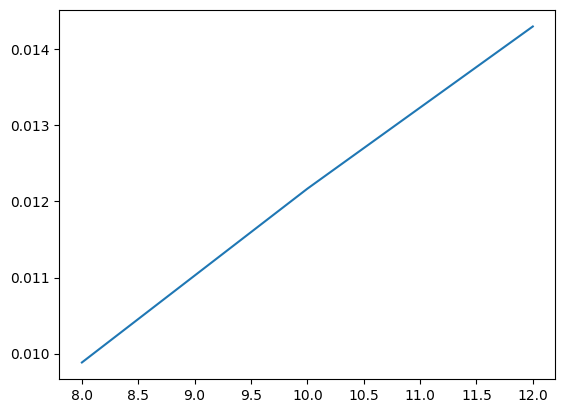

In [317]:
qs = []
windows = [8, 10, 12]
for holding_window in windows:

    # Labels erstellen
    labeled_data = create_labels(df_hour, window=holding_window)

    #dt_indicators.extend([f'EMA_{5}', f'EMA_{50}', f'EMA_{500}'])
    # Liste der Indikatoren
    features = dt_indicators

    # Beste Indikatoren finden
    best_model, best_combination, best_sharpe, train_sharpe_ratios, test_sharpe_ratios, models, combos = find_best_indicators(labeled_data, 
                                                                                                                            features, 
                                                                                                                            holding_period=holding_window, 
                                                                                                                            target="label", 
                                                                                                                            signal_threshold=0.6,
                                                                                                                            plot=False)
    res = pd.DataFrame.from_dict({"test":test_sharpe_ratios, 
                                "train":train_sharpe_ratios})
    q = res["test"].quantile(0.8)
    qs.append(q)
plt.plot(windows, qs)

Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000115, std=0.006357
mean=0.000094, std=0.006358
mean=0.000104, std=0.004730
mean=0.000081, std=0.004732
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000086, std=0.006202
mean=0.000065, std=0.006203
mean=0.000053, std=0.004503
mean=0.000033, std=0.004504
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000125, std=0.006604
mean=0.000106, std=0.006605
mean=0.000008, std=0.004539
mean=-0.000010, std=0.004540
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000101, std=0.006735
mean=0.000082, std=0.006735
mean=0.000024, std=0.004518
mean=0.000007, std=0.004520
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000089, std=0.006198
mean=0.000070, std=0.006199
mean=0.000055, std=0.004521
mean=0.000036, std=0.004522
Fitting 4 folds for each of 1 candidates, to

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000132, std=0.006599
mean=0.000113, std=0.006601
mean=0.000017, std=0.004655
mean=-0.000002, std=0.004656
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000084, std=0.006114
mean=0.000066, std=0.006115
mean=0.000100, std=0.004598
mean=0.000081, std=0.004600
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000121, std=0.006517
mean=0.000101, std=0.006518
mean=0.000088, std=0.004777
mean=0.000069, std=0.004779
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000012, std=0.001342
mean=0.000010, std=0.001342
mean=0.000005, std=0.000865
mean=0.000003, std=0.000865
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000105, std=0.005890
mean=0.000088, std=0.005891
mean=0.000064, std=0.004470
mean=0.000046, std=0.004471
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000086, std=0.005

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000185, std=0.006147
mean=0.000171, std=0.006149
mean=0.000069, std=0.004335
mean=0.000055, std=0.004336
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000132, std=0.006482
mean=0.000118, std=0.006484
mean=0.000100, std=0.004526
mean=0.000085, std=0.004527
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000178, std=0.006128
mean=0.000162, std=0.006129
mean=0.000045, std=0.004637
mean=0.000030, std=0.004637
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000118, std=0.005616
mean=0.000095, std=0.005617
mean=0.000036, std=0.004218
mean=0.000013, std=0.004219
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000125, std=0.005835
mean=0.000111, std=0.005835
mean=0.000074, std=0.003770
mean=0.000060, std=0.003771
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000093, std=0.0059

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000161, std=0.006181
mean=0.000146, std=0.006182
mean=0.000093, std=0.004380
mean=0.000079, std=0.004381
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000092, std=0.005614
mean=0.000069, std=0.005616
mean=0.000011, std=0.004123
mean=-0.000011, std=0.004126
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000129, std=0.006666
mean=0.000112, std=0.006667
mean=0.000065, std=0.004705
mean=0.000049, std=0.004706
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000151, std=0.006328
mean=0.000133, std=0.006329
mean=0.000092, std=0.004487
mean=0.000075, std=0.004486
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000081, std=0.006553
mean=0.000060, std=0.006553
mean=0.000090, std=0.004614
mean=0.000069, std=0.004615
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000126, std=0.006

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000083, std=0.006604
mean=0.000065, std=0.006605
mean=0.000108, std=0.004542
mean=0.000089, std=0.004542
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000180, std=0.006166
mean=0.000166, std=0.006167
mean=0.000079, std=0.004507
mean=0.000065, std=0.004507
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000065, std=0.005872
mean=0.000046, std=0.005874
mean=0.000118, std=0.004187
mean=0.000097, std=0.004188
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000089, std=0.005889
mean=0.000071, std=0.005890
mean=0.000097, std=0.004340
mean=0.000079, std=0.004341
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000162, std=0.005756
mean=0.000152, std=0.005757
mean=0.000090, std=0.003607
mean=0.000082, std=0.003607
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000150, std=0.0064

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000112, std=0.006797
mean=0.000092, std=0.006798
mean=0.000056, std=0.004752
mean=0.000037, std=0.004752
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000083, std=0.005571
mean=0.000056, std=0.005572
mean=0.000031, std=0.003813
mean=0.000005, std=0.003815
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000094, std=0.006016
mean=0.000077, std=0.006017
mean=0.000116, std=0.004140
mean=0.000098, std=0.004142
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000125, std=0.006396
mean=0.000109, std=0.006397
mean=0.000047, std=0.004460
mean=0.000031, std=0.004462
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000114, std=0.005339
mean=0.000102, std=0.005340
mean=0.000115, std=0.003699
mean=0.000101, std=0.003699
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000092, std=0.0060

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000186, std=0.006065
mean=0.000169, std=0.006066
mean=0.000062, std=0.004475
mean=0.000045, std=0.004474
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000108, std=0.006482
mean=0.000090, std=0.006483
mean=0.000061, std=0.004706
mean=0.000043, std=0.004707
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000090, std=0.006125
mean=0.000071, std=0.006125
mean=0.000106, std=0.004424
mean=0.000087, std=0.004425
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000152, std=0.006528
mean=0.000135, std=0.006529
mean=0.000073, std=0.004596
mean=0.000055, std=0.004597
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000110, std=0.005575
mean=0.000092, std=0.005576
mean=0.000042, std=0.004276
mean=0.000023, std=0.004276
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000151, std=0.0062

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000099, std=0.006621
mean=0.000078, std=0.006621
mean=0.000075, std=0.004718
mean=0.000052, std=0.004720
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000157, std=0.006489
mean=0.000139, std=0.006491
mean=0.000029, std=0.004543
mean=0.000014, std=0.004544
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000084, std=0.006790
mean=0.000063, std=0.006791
mean=0.000062, std=0.004735
mean=0.000041, std=0.004736
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000196, std=0.006217
mean=0.000182, std=0.006219
mean=0.000059, std=0.004454
mean=0.000044, std=0.004454
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000124, std=0.006787
mean=0.000104, std=0.006788
mean=0.000052, std=0.004721
mean=0.000033, std=0.004724
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000109, std=0.0065

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000135, std=0.006436
mean=0.000119, std=0.006437
mean=0.000080, std=0.004476
mean=0.000064, std=0.004477
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000076, std=0.006102
mean=0.000052, std=0.006104
mean=0.000019, std=0.004544
mean=-0.000003, std=0.004545
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000151, std=0.005952
mean=0.000134, std=0.005954
mean=0.000065, std=0.004331
mean=0.000047, std=0.004333
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000020, std=0.002609
mean=0.000015, std=0.002610
mean=0.000004, std=0.001879
mean=-0.000001, std=0.001882
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000214, std=0.006303
mean=0.000202, std=0.006304
mean=0.000021, std=0.004375
mean=0.000009, std=0.004376
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000104, std=0.00

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000191, std=0.006424
mean=0.000174, std=0.006425
mean=0.000060, std=0.004568
mean=0.000045, std=0.004569
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000000, std=0.000000
mean=0.000000, std=0.000000
mean=0.000000, std=0.000000
mean=0.000000, std=0.000000
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000168, std=0.006182
mean=0.000154, std=0.006183
mean=0.000061, std=0.004299
mean=0.000045, std=0.004301
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000166, std=0.006300
mean=0.000149, std=0.006301
mean=0.000036, std=0.004664
mean=0.000021, std=0.004664
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000013, std=0.002627
mean=0.000006, std=0.002628
mean=0.000019, std=0.001643
mean=0.000013, std=0.001643
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000123, std=0.006682
mean=0.000106, std=0.006683
mean=0.000098, std=0.004705
mean=0.000079, std=0.004708
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000155, std=0.006287
mean=0.000140, std=0.006288
mean=0.000102, std=0.004287
mean=0.000088, std=0.004288
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000168, std=0.0064

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000132, std=0.005640
mean=0.000115, std=0.005642
mean=0.000062, std=0.003984
mean=0.000044, std=0.003985
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000072, std=0.005204
mean=0.000052, std=0.005206
mean=0.000072, std=0.003791
mean=0.000052, std=0.003793
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000043, std=0.004095
mean=0.000027, std=0.004095
mean=0.000021, std=0.002769
mean=0.000005, std=0.002771
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000147, std=0.006164
mean=0.000129, std=0.006165
mean=0.000071, std=0.004460
mean=0.000053, std=0.004461
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000159, std=0.006196
mean=0.000143, std=0.006197
mean=0.000039, std=0.004321
mean=0.000024, std=0.004322
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000139, std=0.0062

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000141, std=0.005437
mean=0.000118, std=0.005438
mean=0.000034, std=0.004129
mean=0.000013, std=0.004130
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000086, std=0.005423
mean=0.000073, std=0.005424
mean=0.000060, std=0.003958
mean=0.000045, std=0.003959
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000119, std=0.005374
mean=0.000106, std=0.005375
mean=0.000007, std=0.003312
mean=-0.000006, std=0.003313
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000152, std=0.006284
mean=0.000135, std=0.006284
mean=0.000024, std=0.004359
mean=0.000007, std=0.004358
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000101, std=0.005345
mean=0.000081, std=0.005347
mean=0.000094, std=0.004027
mean=0.000073, std=0.004030
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000109, std=0.004

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000109, std=0.005112
mean=0.000098, std=0.005113
mean=0.000068, std=0.003749
mean=0.000055, std=0.003750
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000155, std=0.006006
mean=0.000136, std=0.006008
mean=0.000062, std=0.004009
mean=0.000045, std=0.004009
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000000, std=0.000000
mean=0.000000, std=0.000000
mean=0.000000, std=0.000000
mean=0.000000, std=0.000000
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000123, std=0.005566
mean=0.000101, std=0.005567
mean=0.000102, std=0.004256
mean=0.000081, std=0.004258
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000000, std=0.000000
mean=0.000000, std=0.000000
mean=0.000000, std=0.000000
mean=0.000000, std=0.000000
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000100, std=0.004602
mean=0.000081, std=0.004603
mean=0.000021, std=0.003706
mean=-0.000000, std=0.003708
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000155, std=0.006075
mean=0.000139, std=0.006076
mean=0.000047, std=0.004069
mean=0.000033, std=0.004068
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000122, std=0.005981
mean=0.000102, std=0.005983
mean=0.000074, std=0.004419
mean=0.000053, std=0.004421
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000068, std=0.005085
mean=0.000045, std=0.005086
mean=-0.000016, std=0.003634
mean=-0.000038, std=0.003637
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000086, std=0.006279
mean=0.000066, std=0.006280
mean=0.000083, std=0.004274
mean=0.000064, std=0.004273
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000084, std=0.0

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000097, std=0.005591
mean=0.000077, std=0.005592
mean=0.000072, std=0.003928
mean=0.000054, std=0.003931
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000073, std=0.005813
mean=0.000060, std=0.005813
mean=0.000051, std=0.003617
mean=0.000039, std=0.003620
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000093, std=0.005076
mean=0.000076, std=0.005077
mean=0.000047, std=0.003635
mean=0.000029, std=0.003636
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000013, std=0.002644
mean=0.000006, std=0.002645
mean=0.000019, std=0.001645
mean=0.000013, std=0.001645
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000162, std=0.006079
mean=0.000145, std=0.006081
mean=0.000101, std=0.004164
mean=0.000084, std=0.004165
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000000, std=0.0000

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000116, std=0.005336
mean=0.000104, std=0.005336
mean=-0.000009, std=0.003265
mean=-0.000021, std=0.003264
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000134, std=0.005635
mean=0.000112, std=0.005636
mean=0.000074, std=0.004146
mean=0.000053, std=0.004148
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000079, std=0.006105
mean=0.000060, std=0.006106
mean=0.000074, std=0.004217
mean=0.000054, std=0.004219
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000162, std=0.006254
mean=0.000143, std=0.006255
mean=0.000074, std=0.004522
mean=0.000053, std=0.004525
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000153, std=0.005512
mean=0.000142, std=0.005515
mean=0.000104, std=0.004072
mean=0.000093, std=0.004071
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000109, std=0.00

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000184, std=0.006107
mean=0.000164, std=0.006109
mean=0.000062, std=0.004419
mean=0.000043, std=0.004420
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000111, std=0.005568
mean=0.000095, std=0.005569
mean=0.000017, std=0.003806
mean=-0.000000, std=0.003808
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000203, std=0.005838
mean=0.000190, std=0.005839
mean=0.000026, std=0.003830
mean=0.000014, std=0.003830
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000160, std=0.005895
mean=0.000140, std=0.005896
mean=0.000024, std=0.004566
mean=0.000004, std=0.004568
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000000, std=0.000000
mean=0.000000, std=0.000000
mean=0.000000, std=0.000000
mean=0.000000, std=0.000000
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000131, std=0.005912
mean=0.000117, std=0.005914
mean=0.000073, std=0.003727
mean=0.000062, std=0.003727
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000108, std=0.005340
mean=0.000098, std=0.005340
mean=0.000053, std=0.003296
mean=0.000044, std=0.003295
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000193, std=0.005499
mean=0.000180, std=0.005500
mean=0.000053, std=0.004041
mean=0.000038, std=0.004044
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000098, std=0.005695
mean=0.000083, std=0.005696
mean=0.000073, std=0.003797
mean=0.000059, std=0.003798
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000173, std=0.006231
mean=0.000159, std=0.006231
mean=0.000095, std=0.004184
mean=0.000078, std=0.004186
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000109, std=0.0063

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000209, std=0.006177
mean=0.000194, std=0.006177
mean=0.000050, std=0.004330
mean=0.000036, std=0.004330
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000183, std=0.006132
mean=0.000169, std=0.006132
mean=0.000092, std=0.003994
mean=0.000078, std=0.003995
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000174, std=0.006032
mean=0.000154, std=0.006034
mean=0.000057, std=0.004206
mean=0.000038, std=0.004207
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000136, std=0.005874
mean=0.000116, std=0.005875
mean=0.000064, std=0.004108
mean=0.000044, std=0.004109
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000089, std=0.005277
mean=0.000073, std=0.005278
mean=0.000101, std=0.003822
mean=0.000083, std=0.003823
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000191, std=0.0059

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000090, std=0.005662
mean=0.000078, std=0.005663
mean=0.000057, std=0.003921
mean=0.000046, std=0.003923
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000077, std=0.004633
mean=0.000061, std=0.004634
mean=0.000022, std=0.003637
mean=0.000003, std=0.003640
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000000, std=0.000000
mean=0.000000, std=0.000000
mean=0.000000, std=0.000000
mean=0.000000, std=0.000000
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000090, std=0.004098
mean=0.000078, std=0.004099
mean=0.000047, std=0.003016
mean=0.000036, std=0.003017
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000134, std=0.006246
mean=0.000116, std=0.006248
mean=0.000054, std=0.004321
mean=0.000036, std=0.004323
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000073, std=0.005251
mean=0.000062, std=0.005252
mean=0.000062, std=0.003261
mean=0.000052, std=0.003260
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000110, std=0.006362
mean=0.000091, std=0.006363
mean=0.000072, std=0.004238
mean=0.000054, std=0.004237
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000117, std=0.006150
mean=0.000100, std=0.006152
mean=0.000054, std=0.004321
mean=0.000036, std=0.004324
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000200, std=0.0059

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000108, std=0.006397
mean=0.000091, std=0.006398
mean=0.000022, std=0.004087
mean=0.000007, std=0.004090
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000197, std=0.006349
mean=0.000179, std=0.006350
mean=0.000097, std=0.004485
mean=0.000079, std=0.004487
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000200, std=0.005793
mean=0.000185, std=0.005795
mean=0.000037, std=0.003794
mean=0.000023, std=0.003794
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000142, std=0.006115
mean=0.000124, std=0.006116
mean=0.000048, std=0.004299
mean=0.000030, std=0.004302
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000150, std=0.005870
mean=0.000137, std=0.005871
mean=0.000113, std=0.003778
mean=0.000100, std=0.003778
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000149, std=0.0063

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000147, std=0.006128
mean=0.000132, std=0.006130
mean=0.000057, std=0.004123
mean=0.000042, std=0.004124
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000159, std=0.005899
mean=0.000146, std=0.005900
mean=0.000089, std=0.004296
mean=0.000077, std=0.004300
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000173, std=0.006239
mean=0.000155, std=0.006240
mean=0.000024, std=0.004329
mean=0.000008, std=0.004331
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000155, std=0.006092
mean=0.000132, std=0.006093
mean=0.000034, std=0.004702
mean=0.000013, std=0.004705
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000096, std=0.005444
mean=0.000081, std=0.005445
mean=0.000037, std=0.004014
mean=0.000020, std=0.004015
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000135, std=0.0054

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000094, std=0.005678
mean=0.000074, std=0.005679
mean=0.000128, std=0.004253
mean=0.000109, std=0.004252
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000085, std=0.005565
mean=0.000073, std=0.005566
mean=0.000066, std=0.004131
mean=0.000053, std=0.004131
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000236, std=0.006033
mean=0.000220, std=0.006034
mean=0.000010, std=0.004174
mean=-0.000004, std=0.004176
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000162, std=0.006033
mean=0.000140, std=0.006034
mean=0.000092, std=0.004688
mean=0.000070, std=0.004689
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000167, std=0.006197
mean=0.000151, std=0.006197
mean=0.000027, std=0.004236
mean=0.000014, std=0.004240
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000104, std=0.004

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000124, std=0.005370
mean=0.000103, std=0.005370
mean=-0.000010, std=0.003970
mean=-0.000029, std=0.003971
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000174, std=0.006192
mean=0.000154, std=0.006193
mean=0.000078, std=0.004398
mean=0.000058, std=0.004398
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000188, std=0.006102
mean=0.000170, std=0.006104
mean=0.000032, std=0.004240
mean=0.000016, std=0.004240
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000196, std=0.005965
mean=0.000177, std=0.005966
mean=0.000059, std=0.003959
mean=0.000043, std=0.003959
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000114, std=0.005433
mean=0.000103, std=0.005433
mean=0.000054, std=0.003577
mean=0.000044, std=0.003577
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000147, std=0.00

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000193, std=0.005114
mean=0.000179, std=0.005115
mean=0.000020, std=0.002745
mean=0.000011, std=0.002745
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000000, std=0.000000
mean=0.000000, std=0.000000
mean=0.000000, std=0.000000
mean=0.000000, std=0.000000
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000144, std=0.004285
mean=0.000137, std=0.004286
mean=0.000039, std=0.002983
mean=0.000031, std=0.002984
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000111, std=0.004041
mean=0.000105, std=0.004041
mean=0.000042, std=0.002828
mean=0.000034, std=0.002830
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000076, std=0.002578
mean=0.000067, std=0.002578
mean=-0.000036, std=0.002004
mean=-0.000044, std=0.002006
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000136, std=0.004414
mean=0.000129, std=0.004414
mean=0.000050, std=0.002577
mean=0.000045, std=0.002577
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000000, std=0.000000
mean=0.000000, std=0.000000
mean=0.000000, std=0.000000
mean=0.000000, std=0.000000
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000000, std=0.000000
mean=0.000000, std=0.000000
mean=0.000000, std=0.000000
mean=0.000000, std=0.000000
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000112, std=0.004192
mean=0.000102, std=0.004193
mean=0.000026, std=0.002611
mean=0.000014, std=0.002610
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000074, std=0.004596
mean=0.000065, std=0.004596
mean=0.000021, std=0.002327
mean=0.000014, std=0.002327
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000166, std=0.004760
mean=0.000157, std=0.004761
mean=0.000054, std=0.002871
mean=0.000046, std=0.002871
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000193, std=0.005209
mean=0.000183, std=0.005209
mean=0.000032, std=0.003270
mean=0.000024, std=0.003272
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000047, std=0.003211
mean=0.000042, std=0.003210
mean=0.000043, std=0.002265
mean=0.000041, std=0.002265
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000126, std=0.0050

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000112, std=0.004752
mean=0.000104, std=0.004753
mean=0.000038, std=0.002903
mean=0.000029, std=0.002904
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000135, std=0.005259
mean=0.000121, std=0.005260
mean=0.000030, std=0.003506
mean=0.000018, std=0.003507
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000078, std=0.003386
mean=0.000066, std=0.003386
mean=-0.000025, std=0.002470
mean=-0.000035, std=0.002471
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000000, std=0.000000
mean=0.000000, std=0.000000
mean=0.000000, std=0.000000
mean=0.000000, std=0.000000
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000031, std=0.002187
mean=0.000029, std=0.002187
mean=0.000002, std=0.001353
mean=0.000000, std=0.001353
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000039, std=0.002527
mean=0.000032, std=0.002526
mean=-0.000016, std=0.001943
mean=-0.000021, std=0.001943
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000016, std=0.002084
mean=0.000013, std=0.002084
mean=-0.000001, std=0.000712
mean=-0.000004, std=0.000712
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000018, std=0.001023
mean=0.000016, std=0.001023
mean=-0.000002, std=0.000545
mean=-0.000003, std=0.000545
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000067, std=0.003273
mean=0.000062, std=0.003272
mean=0.000052, std=0.002282
mean=0.000049, std=0.002282
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000080, std=

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000035, std=0.002080
mean=0.000030, std=0.002079
mean=-0.000001, std=0.001495
mean=-0.000005, std=0.001495
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000115, std=0.004531
mean=0.000101, std=0.004532
mean=0.000077, std=0.003237
mean=0.000062, std=0.003236
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000046, std=0.002489
mean=0.000042, std=0.002489
mean=0.000005, std=0.001676
mean=0.000002, std=0.001677
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000000, std=0.000000
mean=0.000000, std=0.000000
mean=0.000000, std=0.000000
mean=0.000000, std=0.000000
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000183, std=0.005104
mean=0.000170, std=0.005105
mean=0.000047, std=0.003073
mean=0.000035, std=0.003075
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000118, std=0.005360
mean=0.000107, std=0.005360
mean=0.000044, std=0.003177
mean=0.000035, std=0.003177
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000060, std=0.003400
mean=0.000056, std=0.003399
mean=0.000011, std=0.001691
mean=0.000009, std=0.001692
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000000, std=0.000000
mean=0.000000, std=0.000000
mean=0.000000, std=0.000000
mean=0.000000, std=0.000000
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000084, std=0.002492
mean=0.000076, std=0.002490
mean=0.000023, std=0.001359
mean=0.000016, std=0.001360
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000119, std=0.003934
mean=0.000110, std=0.003935
mean=0.000025, std=0.002575
mean=0.000017, std=0.002575
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000101, std=0.002925
mean=0.000090, std=0.002925
mean=0.000029, std=0.002366
mean=0.000016, std=0.002369
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000155, std=0.004091
mean=0.000147, std=0.004092
mean=0.000053, std=0.003052
mean=0.000043, std=0.003052
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000000, std=0.000000
mean=0.000000, std=0.000000
mean=0.000000, std=0.000000
mean=0.000000, std=0.000000
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000000, std=0.000000
mean=0.000000, std=0.000000
mean=0.000000, std=0.000000
mean=0.000000, std=0.000000
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000158, std=0.005371
mean=0.000145, std=0.005372
mean=0.000040, std=0.003446
mean=0.000028, std=0.003448
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000164, std=0.005010
mean=0.000152, std=0.005010
mean=0.000028, std=0.003017
mean=0.000018, std=0.003018
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000059, std=0.002980
mean=0.000051, std=0.002979
mean=-0.000024, std=0.001924
mean=-0.000032, std=0.001925
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000083, std=0.004138
mean=0.000074, std=0.004138
mean=0.000009, std=0.002337
mean=-0.000001, std=0.002336
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000140, std=0.005014
mean=0.000127, std=0.005016
mean=0.000047, std=0.003037
mean=0.000035, std=0.003039
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000028, std=0.0

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000100, std=0.002701
mean=0.000090, std=0.002703
mean=0.000022, std=0.002435
mean=0.000012, std=0.002438
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000116, std=0.004459
mean=0.000109, std=0.004460
mean=0.000005, std=0.002135
mean=-0.000000, std=0.002137
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000060, std=0.003447
mean=0.000047, std=0.003448
mean=0.000024, std=0.002740
mean=0.000012, std=0.002738
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000067, std=0.003873
mean=0.000062, std=0.003873
mean=0.000014, std=0.001961
mean=0.000011, std=0.001962
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000087, std=0.004500
mean=0.000076, std=0.004500
mean=-0.000022, std=0.002855
mean=-0.000032, std=0.002855
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000020, std=0.0

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000077, std=0.004219
mean=0.000070, std=0.004220
mean=0.000010, std=0.002361
mean=0.000001, std=0.002362
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000039, std=0.002623
mean=0.000036, std=0.002623
mean=-0.000003, std=0.001799
mean=-0.000004, std=0.001799
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000012, std=0.001661
mean=0.000010, std=0.001662
mean=-0.000008, std=0.001515
mean=-0.000011, std=0.001517
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000000, std=0.000000
mean=0.000000, std=0.000000
mean=0.000000, std=0.000000
mean=0.000000, std=0.000000
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000159, std=0.005007
mean=0.000145, std=0.005006
mean=0.000032, std=0.003324
mean=0.000021, std=0.003324
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000123, std=0.004935
mean=0.000110, std=0.004935
mean=0.000057, std=0.003065
mean=0.000046, std=0.003063
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000131, std=0.004086
mean=0.000119, std=0.004087
mean=0.000019, std=0.002855
mean=0.000008, std=0.002857
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000172, std=0.004844
mean=0.000162, std=0.004845
mean=0.000026, std=0.003235
mean=0.000016, std=0.003235
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000000, std=0.000000
mean=0.000000, std=0.000000
mean=0.000000, std=0.000000
mean=0.000000, std=0.000000
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000013, std=0.001344
mean=0.000010, std=0.001345
mean=0.000011, std=0.001174
mean=0.000008, std=0.001173
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000067, std=0.003822
mean=0.000060, std=0.003822
mean=0.000008, std=0.002461
mean=0.000003, std=0.002462
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000159, std=0.004813
mean=0.000150, std=0.004814
mean=0.000042, std=0.003259
mean=0.000035, std=0.003261
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000059, std=0.002500
mean=0.000051, std=0.002499
mean=0.000027, std=0.001634
mean=0.000019, std=0.001633
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000129, std=0.003951
mean=0.000118, std=0.003952
mean=0.000080, std=0.002902
mean=0.000069, std=0.002902
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000000, std=0.0000

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000051, std=0.002886
mean=0.000046, std=0.002887
mean=0.000034, std=0.001639
mean=0.000028, std=0.001640
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000032, std=0.002036
mean=0.000027, std=0.002036
mean=0.000004, std=0.001611
mean=-0.000002, std=0.001613
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000061, std=0.003279
mean=0.000056, std=0.003281
mean=0.000035, std=0.002435
mean=0.000028, std=0.002436
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000101, std=0.005174
mean=0.000088, std=0.005174
mean=0.000010, std=0.003198
mean=0.000000, std=0.003198
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000131, std=0.004314
mean=0.000119, std=0.004313
mean=0.000000, std=0.002927
mean=-0.000011, std=0.002927
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000138, std=0.00

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000100, std=0.004663
mean=0.000089, std=0.004664
mean=0.000049, std=0.002846
mean=0.000037, std=0.002846
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000000, std=0.000000
mean=0.000000, std=0.000000
mean=0.000000, std=0.000000
mean=0.000000, std=0.000000
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000056, std=0.003000
mean=0.000050, std=0.003001
mean=0.000021, std=0.002281
mean=0.000015, std=0.002280
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000134, std=0.005177
mean=0.000121, std=0.005178
mean=0.000052, std=0.003362
mean=0.000039, std=0.003361
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000158, std=0.004808
mean=0.000144, std=0.004809
mean=0.000026, std=0.003348
mean=0.000012, std=0.003349
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000168, std=0.004986
mean=0.000158, std=0.004987
mean=0.000041, std=0.003035
mean=0.000034, std=0.003034
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000198, std=0.004832
mean=0.000189, std=0.004832
mean=0.000021, std=0.002773
mean=0.000013, std=0.002773
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000093, std=0.0046

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000133, std=0.004924
mean=0.000120, std=0.004925
mean=0.000006, std=0.003120
mean=-0.000007, std=0.003121
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000160, std=0.004976
mean=0.000149, std=0.004977
mean=0.000027, std=0.002979
mean=0.000019, std=0.002980
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000055, std=0.002478
mean=0.000049, std=0.002478
mean=0.000003, std=0.001563
mean=-0.000003, std=0.001564
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000159, std=0.005215
mean=0.000149, std=0.005216
mean=0.000048, std=0.003341
mean=0.000038, std=0.003342
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000000, std=0.000000
mean=0.000000, std=0.000000
mean=0.000000, std=0.000000
mean=0.000000, std=0.000000
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000177, std=0.004930
mean=0.000168, std=0.004931
mean=0.000068, std=0.003192
mean=0.000058, std=0.003193
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000013, std=0.002189
mean=0.000010, std=0.002188
mean=-0.000000, std=0.000839
mean=-0.000004, std=0.000841
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000055, std=0.003356
mean=0.000048, std=0.003356
mean=-0.000004, std=0.002109
mean=-0.000010, std=0.002109
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000192, std=0.005308
mean=0.000182, std=0.005309
mean=0.000074, std=0.003503
mean=0.000064, std=0.003506
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000067, std=0.004465
mean=0.000059, std=0.004465
mean=0.000067, std=0.002555
mean=0.000061, std=0.002551
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000147, std=0.

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000136, std=0.004914
mean=0.000127, std=0.004915
mean=0.000051, std=0.002899
mean=0.000042, std=0.002900
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000175, std=0.005027
mean=0.000163, std=0.005029
mean=0.000023, std=0.003262
mean=0.000010, std=0.003264
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000167, std=0.005016
mean=0.000156, std=0.005016
mean=0.000047, std=0.003047
mean=0.000037, std=0.003046
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000242, std=0.005216
mean=0.000229, std=0.005216
mean=0.000012, std=0.003583
mean=0.000001, std=0.003583
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000170, std=0.005069
mean=0.000160, std=0.005069
mean=0.000001, std=0.003028
mean=-0.000007, std=0.003030
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000141, std=0.004

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000166, std=0.005172
mean=0.000151, std=0.005174
mean=0.000098, std=0.003431
mean=0.000084, std=0.003430
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000160, std=0.005255
mean=0.000144, std=0.005255
mean=-0.000013, std=0.003518
mean=-0.000025, std=0.003519
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000107, std=0.004042
mean=0.000092, std=0.004043
mean=0.000028, std=0.002975
mean=0.000013, std=0.002976
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000110, std=0.004260
mean=0.000096, std=0.004261
mean=0.000042, std=0.002697
mean=0.000029, std=0.002697
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000142, std=0.005270
mean=0.000128, std=0.005271
mean=-0.000004, std=0.003342
mean=-0.000014, std=0.003341
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000060, std=0.

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000138, std=0.004368
mean=0.000126, std=0.004370
mean=-0.000046, std=0.002914
mean=-0.000058, std=0.002915
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000137, std=0.004887
mean=0.000126, std=0.004888
mean=0.000038, std=0.003237
mean=0.000027, std=0.003238
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000124, std=0.003983
mean=0.000115, std=0.003983
mean=-0.000008, std=0.002767
mean=-0.000019, std=0.002769
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000107, std=0.004192
mean=0.000099, std=0.004192
mean=0.000049, std=0.003102
mean=0.000040, std=0.003103
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000182, std=0.004992
mean=0.000168, std=0.004992
mean=0.000054, std=0.003212
mean=0.000042, std=0.003213
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000135, std=0.

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000121, std=0.003945
mean=0.000107, std=0.003944
mean=0.000026, std=0.002670
mean=0.000013, std=0.002669
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000136, std=0.003472
mean=0.000124, std=0.003472
mean=0.000029, std=0.002630
mean=0.000015, std=0.002632
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000114, std=0.003673
mean=0.000103, std=0.003673
mean=0.000022, std=0.002982
mean=0.000010, std=0.002983
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000112, std=0.004508
mean=0.000103, std=0.004509
mean=0.000025, std=0.002141
mean=0.000019, std=0.002141
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000081, std=0.003021
mean=0.000073, std=0.003020
mean=0.000025, std=0.002167
mean=0.000018, std=0.002167
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000119, std=0.0045

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000211, std=0.005488
mean=0.000197, std=0.005488
mean=0.000070, std=0.003175
mean=0.000059, std=0.003177
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000223, std=0.005054
mean=0.000210, std=0.005055
mean=0.000050, std=0.003675
mean=0.000036, std=0.003675
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000211, std=0.005238
mean=0.000200, std=0.005238
mean=0.000003, std=0.003565
mean=-0.000005, std=0.003566
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000127, std=0.003816
mean=0.000117, std=0.003817
mean=0.000038, std=0.002952
mean=0.000028, std=0.002952
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000173, std=0.004890
mean=0.000159, std=0.004890
mean=0.000002, std=0.003004
mean=-0.000008, std=0.003004
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000212, std=0.00

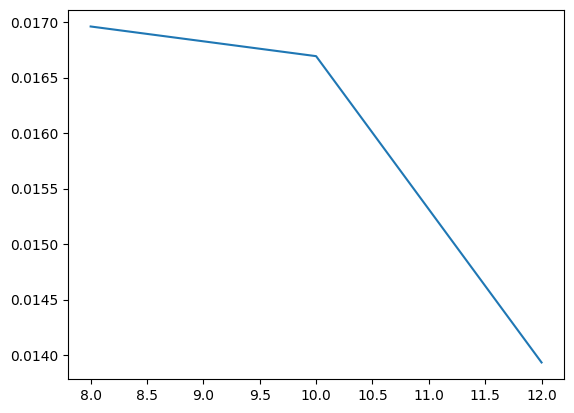

In [318]:
qs = []
ths = [0.53, 0.55, 0.6]
for th in ths:

    # Labels erstellen
    labeled_data = create_labels(df_hour, window=holding_window)

    #dt_indicators.extend([f'EMA_{5}', f'EMA_{50}', f'EMA_{500}'])
    # Liste der Indikatoren
    features = dt_indicators

    # Beste Indikatoren finden
    best_model, best_combination, best_sharpe, train_sharpe_ratios, test_sharpe_ratios, models, combos = find_best_indicators(labeled_data, 
                                                                                                                            features, 
                                                                                                                            holding_period=holding_window, 
                                                                                                                            target="label", 
                                                                                                                            signal_threshold=th,
                                                                                                                            plot=False)
    res = pd.DataFrame.from_dict({"test":test_sharpe_ratios, 
                                "train":train_sharpe_ratios})
    q = res["test"].quantile(0.8)
    qs.append(q)
plt.plot(windows, qs)

In [319]:
HOLDING_WINDOW = 12
SIG_TH = 0.55

In [320]:
# Labels erstellen
labeled_data = create_labels(df_hour, window=HOLDING_WINDOW)

# Liste der Indikatoren
features = dt_indicators

# Beste Indikatoren finden
best_model, best_combination, best_sharpe, train_sharpe_ratios, test_sharpe_ratios, models, combos = find_best_indicators(labeled_data, 
                                                                                                                        features, 
                                                                                                                        holding_period=HOLDING_WINDOW, 
                                                                                                                        target="label", 
                                                                                                                        signal_threshold=SIG_TH,
                                                                                                                        plot=False)

Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000182, std=0.005751
mean=0.000169, std=0.005753
mean=0.000048, std=0.003437
mean=0.000037, std=0.003437
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000000, std=0.000000
mean=0.000000, std=0.000000
mean=0.000000, std=0.000000
mean=0.000000, std=0.000000
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000086, std=0.005423
mean=0.000073, std=0.005424
mean=0.000060, std=0.003958
mean=0.000045, std=0.003959
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000116, std=0.004067
mean=0.000103, std=0.004068
mean=0.000067, std=0.003497
mean=0.000053, std=0.003500
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000120, std=0.006364
mean=0.000100, std=0.006366
mean=0.000060, std=0.004483
mean=0.000041, std=0.004485
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000120, std=0.005745
mean=0.000108, std=0.005745
mean=0.000032, std=0.003808
mean=0.000022, std=0.003806
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000164, std=0.006148
mean=0.000145, std=0.006149
mean=0.000055, std=0.004274
mean=0.000037, std=0.004275
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000134, std=0.0061

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000208, std=0.005962
mean=0.000193, std=0.005962
mean=0.000036, std=0.003893
mean=0.000024, std=0.003893
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000072, std=0.005163
mean=0.000062, std=0.005163
mean=0.000073, std=0.003534
mean=0.000063, std=0.003536
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000164, std=0.005115
mean=0.000154, std=0.005116
mean=0.000049, std=0.003021
mean=0.000043, std=0.003021
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000161, std=0.005858
mean=0.000148, std=0.005859
mean=0.000050, std=0.003859
mean=0.000036, std=0.003859
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000097, std=0.005449
mean=0.000082, std=0.005449
mean=0.000061, std=0.003874
mean=0.000046, std=0.003874
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000121, std=0.0049

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000098, std=0.004611
mean=0.000076, std=0.004611
mean=0.000021, std=0.003135
mean=0.000000, std=0.003135
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000098, std=0.005347
mean=0.000087, std=0.005348
mean=0.000033, std=0.002908
mean=0.000023, std=0.002907
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000097, std=0.004921
mean=0.000085, std=0.004922
mean=0.000032, std=0.003367
mean=0.000019, std=0.003369
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000137, std=0.005730
mean=0.000125, std=0.005731
mean=0.000083, std=0.003626
mean=0.000071, std=0.003626
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000146, std=0.006147
mean=0.000131, std=0.006148
mean=0.000075, std=0.004094
mean=0.000060, std=0.004096
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000139, std=0.0060

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000116, std=0.005485
mean=0.000094, std=0.005486
mean=0.000100, std=0.004141
mean=0.000079, std=0.004144
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000199, std=0.005380
mean=0.000185, std=0.005382
mean=0.000073, std=0.004215
mean=0.000057, std=0.004215
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000188, std=0.005377
mean=0.000175, std=0.005378
mean=0.000059, std=0.004125
mean=0.000044, std=0.004127
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000072, std=0.004507
mean=0.000058, std=0.004509
mean=0.000061, std=0.003329
mean=0.000046, std=0.003330
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000124, std=0.005967
mean=0.000108, std=0.005968
mean=0.000067, std=0.004026
mean=0.000051, std=0.004025
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000121, std=0.0053

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000166, std=0.005756
mean=0.000153, std=0.005756
mean=0.000076, std=0.003760
mean=0.000064, std=0.003761
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000169, std=0.005779
mean=0.000148, std=0.005780
mean=0.000057, std=0.004142
mean=0.000036, std=0.004141
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000125, std=0.005907
mean=0.000109, std=0.005909
mean=0.000064, std=0.004155
mean=0.000047, std=0.004156
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000137, std=0.006320
mean=0.000121, std=0.006321
mean=0.000060, std=0.004338
mean=0.000043, std=0.004341
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000093, std=0.005625
mean=0.000073, std=0.005626
mean=0.000079, std=0.003994
mean=0.000061, std=0.003995
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000208, std=0.0057

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000115, std=0.004519
mean=0.000099, std=0.004520
mean=0.000062, std=0.003336
mean=0.000044, std=0.003336
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000105, std=0.005032
mean=0.000089, std=0.005033
mean=0.000020, std=0.003750
mean=0.000002, std=0.003750
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000165, std=0.005985
mean=0.000149, std=0.005987
mean=0.000036, std=0.003892
mean=0.000021, std=0.003892
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000125, std=0.006383
mean=0.000109, std=0.006384
mean=0.000066, std=0.004271
mean=0.000049, std=0.004273
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000099, std=0.005637
mean=0.000078, std=0.005637
mean=0.000078, std=0.004027
mean=0.000057, std=0.004028
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000076, std=0.0056

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000043, std=0.005141
mean=0.000021, std=0.005142
mean=0.000039, std=0.003787
mean=0.000018, std=0.003788
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000189, std=0.005680
mean=0.000175, std=0.005680
mean=0.000017, std=0.003893
mean=0.000005, std=0.003893
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000003, std=0.001084
mean=0.000002, std=0.001085
mean=-0.000003, std=0.000544
mean=-0.000003, std=0.000545
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000203, std=0.005547
mean=0.000190, std=0.005548
mean=0.000057, std=0.003751
mean=0.000047, std=0.003750
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000165, std=0.006054
mean=0.000145, std=0.006055
mean=0.000091, std=0.004468
mean=0.000070, std=0.004470
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000094, std=0.00

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000127, std=0.005869
mean=0.000112, std=0.005870
mean=0.000089, std=0.004101
mean=0.000072, std=0.004100
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000080, std=0.005442
mean=0.000068, std=0.005443
mean=0.000047, std=0.003685
mean=0.000035, std=0.003688
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000097, std=0.004403
mean=0.000081, std=0.004405
mean=0.000058, std=0.003346
mean=0.000044, std=0.003350
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000155, std=0.006061
mean=0.000138, std=0.006062
mean=0.000084, std=0.003891
mean=0.000069, std=0.003889
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000167, std=0.005958
mean=0.000151, std=0.005959
mean=0.000065, std=0.004320
mean=0.000049, std=0.004322
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000087, std=0.0053

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000196, std=0.005987
mean=0.000180, std=0.005988
mean=0.000063, std=0.004102
mean=0.000049, std=0.004103
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000170, std=0.005967
mean=0.000151, std=0.005969
mean=0.000092, std=0.004366
mean=0.000073, std=0.004366
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000183, std=0.006099
mean=0.000166, std=0.006100
mean=0.000023, std=0.004338
mean=0.000006, std=0.004340
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000139, std=0.006184
mean=0.000121, std=0.006185
mean=0.000066, std=0.004189
mean=0.000049, std=0.004191
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000160, std=0.006402
mean=0.000141, std=0.006402
mean=0.000094, std=0.004377
mean=0.000075, std=0.004377
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000000, std=0.0000

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000086, std=0.004641
mean=0.000071, std=0.004643
mean=0.000045, std=0.003364
mean=0.000031, std=0.003365
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000125, std=0.005669
mean=0.000104, std=0.005671
mean=0.000003, std=0.004059
mean=-0.000019, std=0.004062
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000082, std=0.006183
mean=0.000063, std=0.006184
mean=0.000110, std=0.004154
mean=0.000088, std=0.004154
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000151, std=0.005609
mean=0.000133, std=0.005610
mean=0.000024, std=0.003874
mean=0.000006, std=0.003876
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000131, std=0.005580
mean=0.000110, std=0.005581
mean=0.000094, std=0.004187
mean=0.000074, std=0.004189
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000152, std=0.005

In [321]:
res = pd.DataFrame.from_dict({"test":test_sharpe_ratios, 
                              "train":train_sharpe_ratios})
q = res["test"].quantile(0.8)

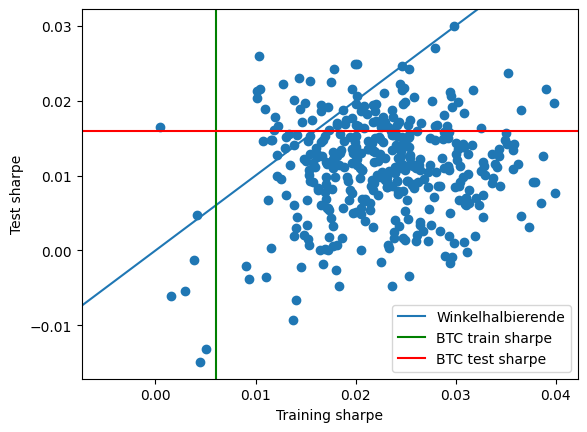

In [322]:
fig, ax = plt.subplots()

ax.scatter(train_sharpe_ratios, test_sharpe_ratios)
ax.axline((min(train_sharpe_ratios), min(train_sharpe_ratios)), slope=1, label="Winkelhalbierende")

train_btc_sharpe=0.006
test_btc_sharpe=0.016  
plt.axvline(x=train_btc_sharpe, color='g', linestyle='-', label="BTC train sharpe")
plt.axhline(y=test_btc_sharpe, color='r', linestyle='-', label="BTC test sharpe")

ax.set_xlabel("Training sharpe")
ax.set_ylabel("Test sharpe")
ax.legend()

In [324]:
# Indices which have above average training and test sharpe ratios
interesting_indices = [idx for idx, val in enumerate(test_sharpe_ratios) if val > test_btc_sharpe and train_sharpe_ratios[idx] > train_btc_sharpe]
res["model_score"] = (res["test"] - test_btc_sharpe) * (res["train"] - train_btc_sharpe)
res.iloc[interesting_indices].sort_values("model_score", ascending=False)[:10]

,test,train,model_score
332,0.029975,0.029843,0.000333
250,0.027006,0.027907,0.000241
360,0.023717,0.035230,0.000226
312,0.021515,0.039055,0.000182
64,0.024663,0.024629,0.000161
395,0.024241,0.025290,0.000159
324,0.021448,0.031698,0.000140
195,0.019749,0.039816,0.000127
361,0.024920,0.020185,0.000127
284,0.024843,0.019922,0.000123


# Select model

In [332]:
################################################
idx = 332
print(combos[idx])
THRESHOLD = 0.6
#################################################

['SMA_24_Sig', 'EMA_168_Sig', 'Momentum_168', 'RSI_720', 'HMA_720_Sig', 'Is_Monday']


In [333]:
models[idx]

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000184, std=0.004826
mean=0.000173, std=0.004827


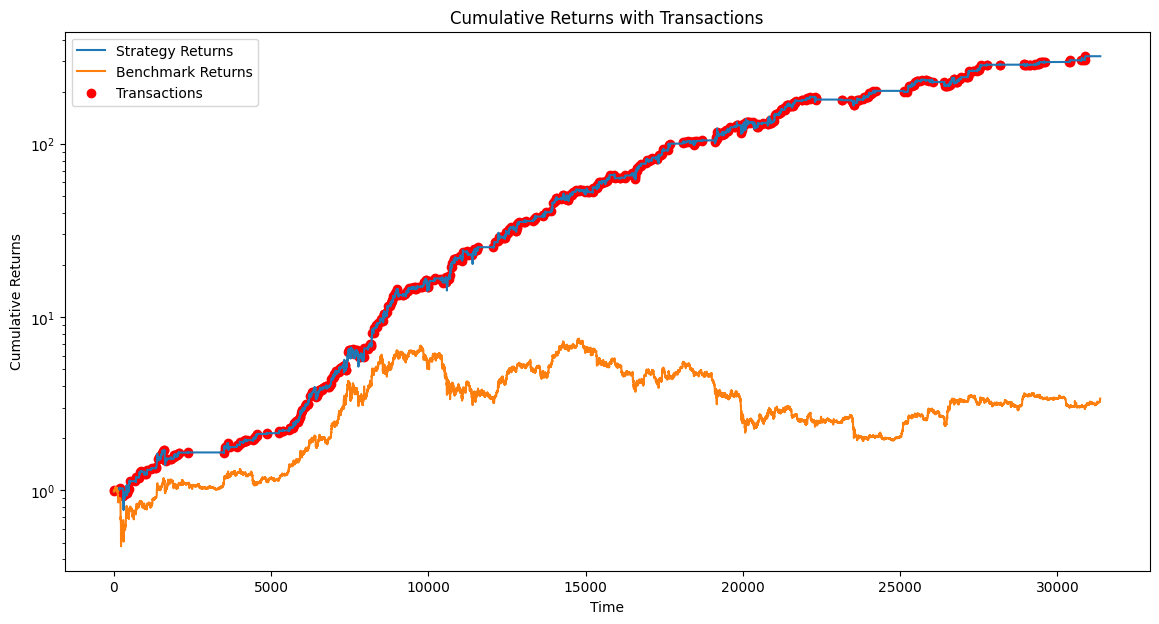

mean=0.000107, std=0.003487
mean=0.000098, std=0.003488


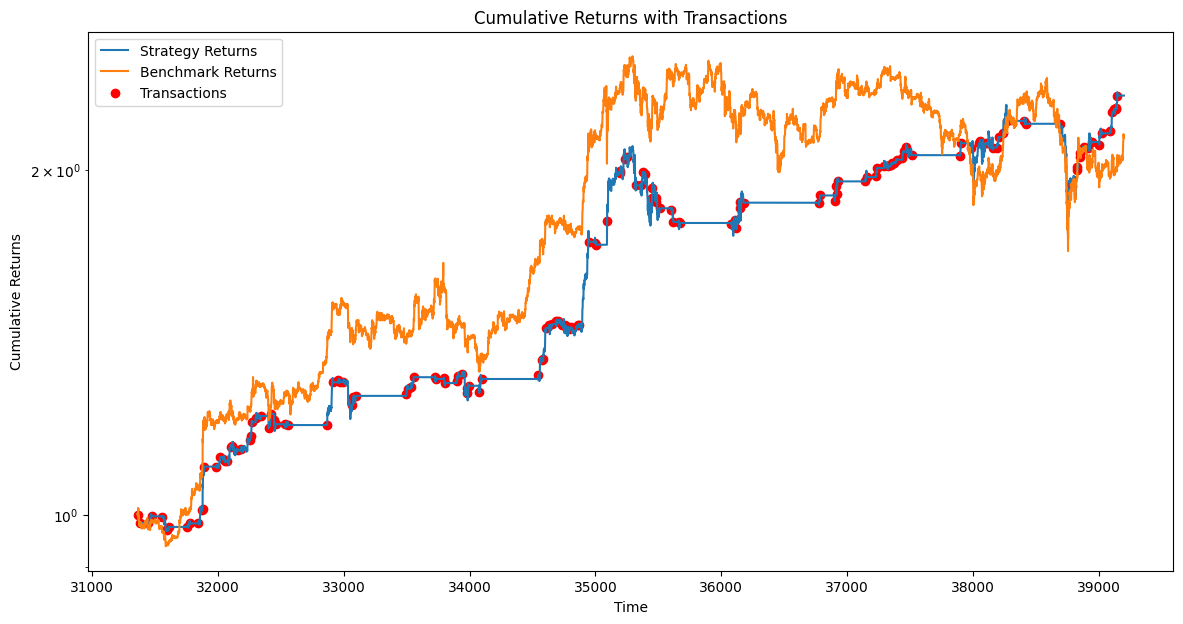

np.float64(0.027965193022161747)

In [334]:
_ESTIMATOR = XGBClassifier(random_state=42, max_depth=3) # DOESNT MATTER , JUST TO GENERATE X_TEST AND X_TRAIN
_, X_test, X_train = train_model(data=labeled_data, features=combos[idx], target="label", param_grid={}, estimator=_ESTIMATOR)

evaluate_model(X_train, models[idx], data=labeled_data, signal_threshold=THRESHOLD, holding_period=HOLDING_WINDOW, plot=True)
evaluate_model(X_test, models[idx], data=labeled_data, signal_threshold=THRESHOLD, holding_period=HOLDING_WINDOW, plot=True)

# Single Model Analysis

In [339]:
################################# HIER 
clf = models[idx]
th = 0.55
sharpe = evaluate_model(X_train, clf, data=labeled_data, signal_threshold=th, holding_period=HOLDING_WINDOW, plot=False)
################################### HIER MODELL INDEX 

mean=0.000196, std=0.006110
mean=0.000182, std=0.006111


In [340]:
sharpe = evaluate_model(X_test, clf, data=labeled_data, signal_threshold=th, holding_period=HOLDING_WINDOW, plot=False)

mean=0.000141, std=0.004241
mean=0.000127, std=0.004243


In [341]:
from functools import partial

plot_func_test = partial(evaluate_model, X_test=X_test, best_clf=clf, data=labeled_data, holding_period=HOLDING_WINDOW, plot=False)
plot_func_train = partial(evaluate_model, X_test=X_train, best_clf=clf, data=labeled_data, holding_period=HOLDING_WINDOW, plot=False)
xs = np.arange(0.5, 1, 0.05)
ys_test = np.ndarray(shape=len(xs))
ys_train = np.ndarray(shape=len(xs))
for i in range(len(xs)):
     ys_test[i] = plot_func_test(signal_threshold=xs[i])
     ys_train[i] = plot_func_train(signal_threshold=xs[i])

mean=0.000105, std=0.004943
mean=0.000092, std=0.004946
mean=0.000164, std=0.006802
mean=0.000150, std=0.006803
mean=0.000141, std=0.004241
mean=0.000127, std=0.004243
mean=0.000196, std=0.006110
mean=0.000182, std=0.006111
mean=0.000107, std=0.003487
mean=0.000098, std=0.003488
mean=0.000184, std=0.004826
mean=0.000173, std=0.004827
mean=0.000055, std=0.002824
mean=0.000049, std=0.002824
mean=0.000120, std=0.003717
mean=0.000114, std=0.003717
mean=-0.000006, std=0.002057
mean=-0.000008, std=0.002058
mean=0.000091, std=0.002976
mean=0.000088, std=0.002976
mean=-0.000003, std=0.001746
mean=-0.000005, std=0.001748
mean=0.000055, std=0.001913
mean=0.000053, std=0.001912
mean=0.000001, std=0.001548
mean=0.000001, std=0.001549
mean=0.000019, std=0.001228
mean=0.000019, std=0.001228
mean=0.000004, std=0.001370
mean=0.000004, std=0.001370
mean=0.000012, std=0.000882
mean=0.000012, std=0.000882
mean=0.000000, std=0.000000
mean=0.000000, std=0.000000
mean=0.000008, std=0.000811
mean=0.000008, s

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Text(0, 0.5, 'sharpe')

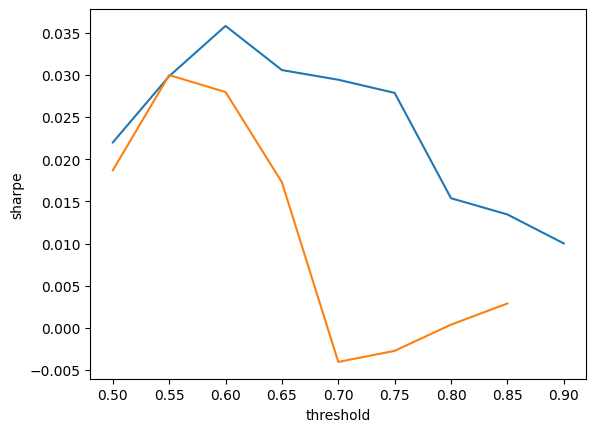

In [342]:
plt.plot(xs, ys_train)
plt.plot(xs, ys_test)
plt.xlabel("threshold")
plt.ylabel("sharpe")

In [343]:
clf

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [344]:
import pickle 
import base64

# Serialize an object into a plain text
def obj_to_txt(obj):
    message_bytes = pickle.dumps(obj)
    base64_bytes = base64.b64encode(message_bytes)
    txt = base64_bytes.decode('ascii')
    return txt

# De-serialize an object from a plain text
def txt_to_obj(txt):
    base64_bytes = txt.encode('ascii')
    message_bytes = base64.b64decode(base64_bytes)
    obj = pickle.loads(message_bytes)
    return obj

In [ ]:
txt = obj_to_txt(clf)

obj = txt_to_obj(txt)

In [ ]:
txt

In [ ]:
plot_func = partial(evaluate_model, X_test=X_test, best_clf=obj, data=labeled_data, holding_period=HOLDING_WINDOW, plot=False)
xs = np.arange(0.5, 1, 0.05)
ys = np.ndarray(shape=len(xs))
for i in range(len(xs)):
     ys[i] = plot_func(signal_threshold=xs[i])
     plt.plot(xs, ys)
plt.xlabel("threshold")
plt.ylabel("sharpe")